In [100]:
#%%capture
#! pip install lightautoml

In [101]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import os, re, time

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# импорт collections для работы с упорядоченным словарём
from collections import OrderedDict

import category_encoders as ce

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# импортируем библиотеки для разделения датасета
from sklearn.model_selection import train_test_split

# импортируем библиотеки для оценки значимости признаков
# from sklearn import feature_selection
from sklearn.feature_selection import chi2 
from sklearn.feature_selection import f_classif

# импортируем библиотеки модели для создания и обучения модели
from sklearn.ensemble import RandomForestRegressor

# LightAutoML presets, task and report generation
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task
import torch

# импортируем библиотеки для оценки точности модели
from sklearn import metrics

# для нормализации, стандартизации
from sklearn import preprocessing

# импорт библиотеки для анализа текста
import nltk 
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.downloader.download('vader_lexicon', quiet = True)

# Определение констант для моделей обучения (в т.ч. lightautoml)
N_THREADS = 4
N_FOLDS = 5
RANDOM_STATE = 117
TEST_SIZE = 0.2
TIMEOUT = 600 # equal to 10 minutes
TARGET_NAME = 'reviewer_score'

# команды для максимальной воспроизводимости
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# INPUT_DIR = '/kaggle/input/sf-booking/'
INPUT_DIR = './data/'

# команды для максимальной воспроизводимости
np.random.seed(RANDOM_STATE)

for dirname, _, filenames in os.walk(INPUT_DIR):
# for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


./data/hotels.csv
./data/hotels_test.csv
./data/hotels_train.csv
./data/submission.csv
./data/submission_laml.csv
./data/submission_rfr.csv


# 1. Загрузка данных и первичный анализ данных

In [102]:
# подгружаем данные из соревнования

# датасет для обучения
df_train = pd.read_csv(INPUT_DIR + '/hotels_train.csv')

# датасет для предсказания
df_test = pd.read_csv(INPUT_DIR + 'hotels_test.csv')

# тестовый сабмишн
sample_submission = pd.read_csv(INPUT_DIR + '/submission.csv')

In [103]:
# чтобы не проводить двойные преобразования df_train и df_test, объединим эти два датасета, 
# а перед запуском обучения модели их разделим, для их различия введём новый признак 'sample'

# помечаем, где у нас трейн
df_train['sample'] = 1

# помечаем, где у нас тест
df_test['sample'] = 0

# в тесте у нас нет значения reviewer_score, мы его должны предсказать, поэтому пока просто заполняем нулями
df_test['reviewer_score'] = 0

# объединяем данные
data = pd.concat([df_test, df_train], sort = False).reset_index(drop = True)

In [104]:
# сверяемся с типом признаков
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

In [105]:
# знакомимся с данными
data.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102,0,0.0
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443,0,0.0
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520,0,0.0


In [106]:
# ищем в столбцах данные, содержащие пропущенные значения
data.isnull().sum()

hotel_address                                    0
additional_number_of_scoring                     0
review_date                                      0
average_score                                    0
hotel_name                                       0
reviewer_nationality                             0
negative_review                                  0
review_total_negative_word_counts                0
total_number_of_reviews                          0
positive_review                                  0
review_total_positive_word_counts                0
total_number_of_reviews_reviewer_has_given       0
tags                                             0
days_since_review                                0
lat                                           3268
lng                                           3268
sample                                           0
reviewer_score                                   0
dtype: int64

Только 2 столбца содержат пропуски в данных:
* lat 
* lng

In [107]:
# ищем в столбцах данные, содержащие числовые значения
digit_columns = [col for col in data.columns if data[col].dtypes != 'object']
digit_columns

['additional_number_of_scoring',
 'average_score',
 'review_total_negative_word_counts',
 'total_number_of_reviews',
 'review_total_positive_word_counts',
 'total_number_of_reviews_reviewer_has_given',
 'lat',
 'lng',
 'sample',
 'reviewer_score']

In [108]:
# ищем в столбцах данные, содержащие строковые значения:
object_columns = [col for col in data.columns if data[col].dtypes == 'object']
object_columns

['hotel_address',
 'review_date',
 'hotel_name',
 'reviewer_nationality',
 'negative_review',
 'positive_review',
 'tags',
 'days_since_review']

# 2. Проектирование признаков

## 2.1. Преобразование признака '*hotel_address*'

* Из него можно выделить два новых признака:
    * страна: '*hotel_country*'
    * город:  '*hotel_city*'
* Страна в строке указана последней, Англия при поиске образуется как '*Kingdom*' — переименуем её как '*United Kingdom*'.
* Город — это второе слово с конца, исключение — Англия, пятое с конца.

In [109]:
# смотрим какие представлены значения
data['hotel_address'].value_counts()

163 Marsh Wall Docklands Tower Hamlets London E14 9SJ United Kingdom              4789
372 Strand Westminster Borough London WC2R 0JJ United Kingdom                     4256
Westminster Bridge Road Lambeth London SE1 7UT United Kingdom                     4169
Scarsdale Place Kensington Kensington and Chelsea London W8 5SY United Kingdom    3578
7 Pepys Street City of London London EC3N 4AF United Kingdom                      3212
                                                                                  ... 
8 rue Fr d ric Bastiat 8th arr 75008 Paris France                                   12
2 4 Boundary Street Hackney London E2 7DD United Kingdom                            12
Via M Buonarroti 13 Fiera Milano City 20149 Milan Italy                             10
13 Rue Fran ois Ory 92120 Paris France                                              10
Johann Staud Stra e 32 16 Ottakring 1160 Vienna Austria                              8
Name: hotel_address, Length: 1493, dtype: i

In [110]:
# выделяем страну
data['hotel_country'] = data['hotel_address'].apply(lambda x: x.split()[-1])

# переименовываем 'Kingdom' -> 'United Kingdom'
data.loc[data['hotel_country'] == 'Kingdom', 'hotel_country'] = 'United Kingdom'

# смотрим какие представлены значения
data['hotel_country'].value_counts()

United Kingdom    262301
Spain              60149
France             59928
Netherlands        57214
Austria            38939
Italy              37207
Name: hotel_country, dtype: int64

In [111]:
# выделяем город
data['hotel_city'] = data['hotel_address'].apply \
(lambda x: x.split()[-5] if x.split()[-1] == 'Kingdom' else x.split()[-2])

# смотрим какие представлены значения
data['hotel_city'].value_counts()

London       262301
Barcelona     60149
Paris         59928
Amsterdam     57214
Vienna        38939
Milan         37207
Name: hotel_city, dtype: int64

In [112]:
# кодируем страну отеля
data['hotel_country'] = data['hotel_country'].astype('category')
data['hotel_country_code'] = data['hotel_country'].cat.codes

# кодируем город отеля
data['hotel_city'] = data['hotel_city'].astype('category')
data['hotel_city_code'] = data['hotel_city'].cat.codes

In [113]:
# проверяем что получилось
data[['hotel_country', 'hotel_country_code', 'hotel_city', 'hotel_city_code']]

,hotel_country,hotel_country_code,hotel_city,hotel_city_code
0,Italy,2,Milan,3
1,Netherlands,3,Amsterdam,0
2,Spain,4,Barcelona,1
3,Italy,2,Milan,3
4,Netherlands,3,Amsterdam,0
...,...,...,...,...
515733,United Kingdom,5,London,2
515734,Austria,0,Vienna,5
515735,United Kingdom,5,London,2
515736,United Kingdom,5,London,2


Получено два новых признака — страна и город отеля, на основании которых, можно с определенной точностью заполнить пропуски в '**lat**', '**lng**'.<br> Заполним их медианными значениями **lat**, **lng** по городам, в которых находятся эти отели.

## 2.2. Преобразование признаков '*lat, lng*' - заполнение пропусков в данных

In [114]:
# посмотрим как пропуски в 'lat' распределяются по городам
print(data[data['lat'].isnull()].groupby('hotel_city', as_index = False).agg(qty = ('hotel_city', 'count')),'\n')

# посмотрим как пропуски в 'lng' распределяются по городам (идентично 'lat')
# print(data[data['lng'].isnull()].groupby('hotel_city', as_index = False).agg(qty = ('hotel_city', 'count')))

  hotel_city   qty
0  Amsterdam     0
1  Barcelona   207
2     London     0
3      Milan     0
4      Paris   382
5     Vienna  2679 



In [115]:
# делаем копию датафрейма для обхода конфликта манипуляций с данными
data_coords = data.copy()

# формируем объект SeriesGroupBy
city_data = data_coords.groupby(['hotel_city'], group_keys = False)

# найдем медианные координаты с учетом образовавшихся групп
city_data['lat'].median()
city_data['lng'].median()

# Применим lambda-функцию к SeriesGroupBy, заменяем пропуски соответствующим медианным значением
data_coords['lat'] = city_data['lat'].apply(lambda x: x.fillna(x.median()))
data_coords['lng'] = city_data['lng'].apply(lambda x: x.fillna(x.median()))

# переносим результат в исходный датафрейм
data = data_coords

# сверяемся с типом признаков
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 22 columns):
 #   Column                                      Non-Null Count   Dtype   
---  ------                                      --------------   -----   
 0   hotel_address                               515738 non-null  object  
 1   additional_number_of_scoring                515738 non-null  int64   
 2   review_date                                 515738 non-null  object  
 3   average_score                               515738 non-null  float64 
 4   hotel_name                                  515738 non-null  object  
 5   reviewer_nationality                        515738 non-null  object  
 6   negative_review                             515738 non-null  object  
 7   review_total_negative_word_counts           515738 non-null  int64   
 8   total_number_of_reviews                     515738 non-null  int64   
 9   positive_review                             515738 non-null

In [116]:
# ищем в столбцах данные, содержащие пропущенные значения
data.isnull().sum()

hotel_address                                 0
additional_number_of_scoring                  0
review_date                                   0
average_score                                 0
hotel_name                                    0
reviewer_nationality                          0
negative_review                               0
review_total_negative_word_counts             0
total_number_of_reviews                       0
positive_review                               0
review_total_positive_word_counts             0
total_number_of_reviews_reviewer_has_given    0
tags                                          0
days_since_review                             0
lat                                           0
lng                                           0
sample                                        0
reviewer_score                                0
hotel_country                                 0
hotel_city                                    0
hotel_country_code                      

**Пропусков в данных больше нет.**

## 2.3. Преобразование признака '*tag*'

Довольно содержательный по сути и "загрязненный" по структуре признак, с его помощью можно создать:

* бинарный признак заказа с мобильного устройства, новый признак — '*tag_from_mobile*', значение 0 (по умолчанию) — заказ был сделан НЕ с мобильного устройства, 1 — заказ с мобильного устройства;
* бинарный признак поездки с домашним питомцем, новый признак — '*tag_with_pet*', где значение 0 (по умолчанию) — заселение без питомца, 1 - с питомцем;
* бинарный признак по типу поездки по наличию тега '**Leisure trip**' или '**Business_trip**', новый признак — '*tag_leisure_trip*', где 0 — деловая поездка, 1 — отдых (по умолчанию);
* категориальный признак по наличию тегов '**Solo traveler**', '**Couple**', '**Travelers with friends**', '**Family with young children**' и другие, новый признак — '*tag_reviewer_type*', где значения от 1 до 6, в зависимости типа состава группы (найденного тега);
* порядковый признак по тегу '**Stayed night(s)**', новый признак — '*tag_count_nights*', основанный на количестве ночей пребывания от 1 до максимального значения, значение по умолчанию - 1, проведена минимально 1 ночь;
* бинарный признак по наличию видовых преимуществ из номера, новый признак — '*tag_view_room*', значение по умолчанию — 0, т.к. не каждый номер с видовыми преимуществами;
* категориальный признак по тегам '**Standard** ...', '**Superior** ...', '**Deluxe** ...', '**Executive** ...' и другие — тип комнаты, новый признак — '*tag_view_room*', основанный на категории комнаты, значение по умолчанию — 0, если тег не будет найден.

In [117]:
# выведем число тегов для каждого отеля в отдельный признак
data['tags_count'] = data['tags'].apply(lambda x: len(re.findall("'[^\'](.+?)[^\']'", x)))

# посмотрим сколько тегов бывает по количеству, ищем максимум 
data['tags_count'].unique()

array([4, 5, 3, 6, 2, 1], dtype=int64)

In [118]:
# смотрим структуру признака 'tag'
print(data[data['tags_count'] == data['tags_count'].max()]['tags'].iloc[0])
print(data[data['tags_count'] == data['tags_count'].max()]['tags'].iloc[1])

[' With a pet ', ' Leisure trip ', ' Family with young children ', ' Double or Twin Room 1 2 Adults ', ' Stayed 7 nights ', ' Submitted from a mobile device ']
[' With a pet ', ' Leisure trip ', ' Couple ', ' Deluxe Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']


Принцип выделения свойств — максимальное количество тегов 6, знаем возможные типы, все, кроме типа комнаты, укладываются в стандартный шаблон.

Будем искать в каждой строке один из 6 известных шаблонов тега и удалять из строки после обработки.
Если останется какой-то еще тег, он и будет типом номера.

In [119]:
def get_tags(tags_string):
    """ Функция кодирования отдельных тегов в новый признак

    Args:
        tags_string (str): строкое значение признака 'tags', передаваемое в обработку

    Returns:
        int: возвращает коды будущих признаков
    """

    # убираем лишнюю информацию (т.н. "мусор")
    tags_string = tags_string.replace('[', '').replace(']', '')
    tags_string = tags_string.replace("' ", '').replace(" '", '')
    
    # "нарезаем" оставшуюся строку тегов во временный список
    tags_list = tags_string.split(',')
    tags_list = list(map(lambda x: x.strip(), tags_list))

    # "кодируем" путешественника(-ов)
    reviewer_types = {
        'Solo traveler': 1,
        'Couple': 2,
        'Travelers with friends': 3,
        'Family with young children': 4,
        'Family with older children': 5,
        'Group': 6
    }

    # "кодируем" тип комнаты
    # словарь "выносится" наружу только ради графиков (для формирования меток по оси абсцисс)
    global room_types
    room_types = {
            'Other': 0,
            'Premier': 1, 'Royal': 2, 'President': 3, 'Presidential': 4, 'Ordinary': 5, 
            'Adjacent': 6, 'Exception': 7, 'Luxury': 8, 'Panoramic': 9, 'Classic': 10, 
            'Loft': 11, 'Montcalm': 12, 'Privilege': 13, 'Special': 14, 'Camper': 15, 
            'Sensation': 16, 'Classique': 17, 'Privilege': 18, 'Wonderful': 19, 'Deluxe': 20,
            'Premium': 21, 'Quadruple': 22, 'Triple': 23, 'Duplex': 24, 'Penthouse': 25, 
            'Townhouse': 26, 'Connecting': 27, 'Apartment': 28, 'Apartments': 29, 'Queen': 30, 
            'King': 31, 'Comfort': 32, 'Large': 33, 'Cosy': 34, 'Cozy': 35, 
            'Extra': 36, 'Plus': 37, 'Club': 38, 'Art': 39, 'View': 40,
            'Studio': 41, 'City': 42, 'Emotion': 43, 'Suite': 44, 'Executive': 45,
            'Superior': 46, 'Guest': 47, 'Family': 48, 'Business': 49,
    }

    # задаем начальные значения новых признаков
    tag_from_mobile = 0
    tag_with_pet = 0
    
    # по умолчанию не считаем поездку командировкой, значение по умолчанию 1
    tag_leisure_trip = 1

    # по умолчанию считаем поездку, что путешественник передвигается один и без детей
    tag_reviewer_type = 1
    
    # если отзыв оставлен и отсутствуют ключевые слова 'Stayed _ night(s)',
    # будем считать, что проведена минимально 1 ночь, значение по умолчанию 1
    tag_count_nights = 1
    
    # номер по умолчанию без видовых преимуществ
    tag_view_room = 0

    # если комната в тегах отсутствует, значение по умолчанию 0
    tag_room_type = 0

    # кодируем значения обнаруженных признаков при их наличии во временном списке
    for _tag in list(tags_list):
        # признак - "отправлено с мобильного устройства"
        if _tag == 'Submitted from a mobile device':
            tag_from_mobile = 1
            tags_list.remove(_tag)

        # признак - путешествие с домашними питомцами
        if _tag == 'With a pet':
            tag_with_pet = 1
            tags_list.remove(_tag)

        # признак - поездка рабочая (командировка)
        if _tag == 'Business trip':
            tag_leisure_trip = 0
            tags_list.remove(_tag)

        # признак - поездка не связана с работой (отпуск)
        if _tag == 'Leisure trip':
            # просто убираем тег из временного списка, т.к. значение по умолчанию 1
            # tag_leisure_trip = 1
            tags_list.remove(_tag)

        # признак - состав путешествующих
        if _tag in reviewer_types.keys():
            tag_reviewer_type = reviewer_types[_tag]
            tags_list.remove(_tag)

        # признак - количество ночей
        if re.fullmatch(r'Stayed\s\d+\snight\w?', _tag):
            tag_count_nights = [int(n) for n in re.findall(r'-?\d+\.?\d*', _tag)][0]
            tags_list.remove(_tag)

        # признак - имеется тег "номер с видом на..."
        if len(tags_list) > 0:
            if ('View' in tags_list[0]) | ('Panoramic' in tags_list[0]):
                tag_view_room = 1

            # кодируем тип номера
            for r_t in room_types.keys():
                if r_t in tags_list[0]:
                    tag_room_type = room_types[r_t]

            # исключения, т.к. тег идет как 'Double or Twin Room 1 2 Adults'
            if ('Double' in tags_list[0]) | ('Twin' in tags_list[0]):
                tag_room_type = 50

    return tag_from_mobile, tag_with_pet, tag_leisure_trip, \
        tag_reviewer_type, tag_count_nights, tag_view_room, tag_room_type

# создаем новые признаки
data[['tag_from_mobile', 'tag_with_pet', 'tag_leisure_trip', 
        'tag_reviewer_type', 'tag_count_nights', 'tag_view_room', 'tag_room_type']
] = pd.DataFrame(data['tags'].apply(get_tags).to_list(), index=data.index).astype('int8')

In [120]:
# задаём маску для отбора тренировочных значений
# БУДЕТ ДЕЙСТВОВАТЬ НА ВСЕ РАСЧЁТЫ
sample_mask = data['sample'] == 1

# смотрим, что получилось по типам помещений 
# визуализация пропусков, какие помещения не закодированы
data[sample_mask].groupby(by = 'tag_room_type')['tag_room_type'].agg(['count']).sort_index(ascending = True)

,count
tag_room_type,
0,21749
1,180
2,45
4,2
5,66
6,83
7,1
8,361
9,21


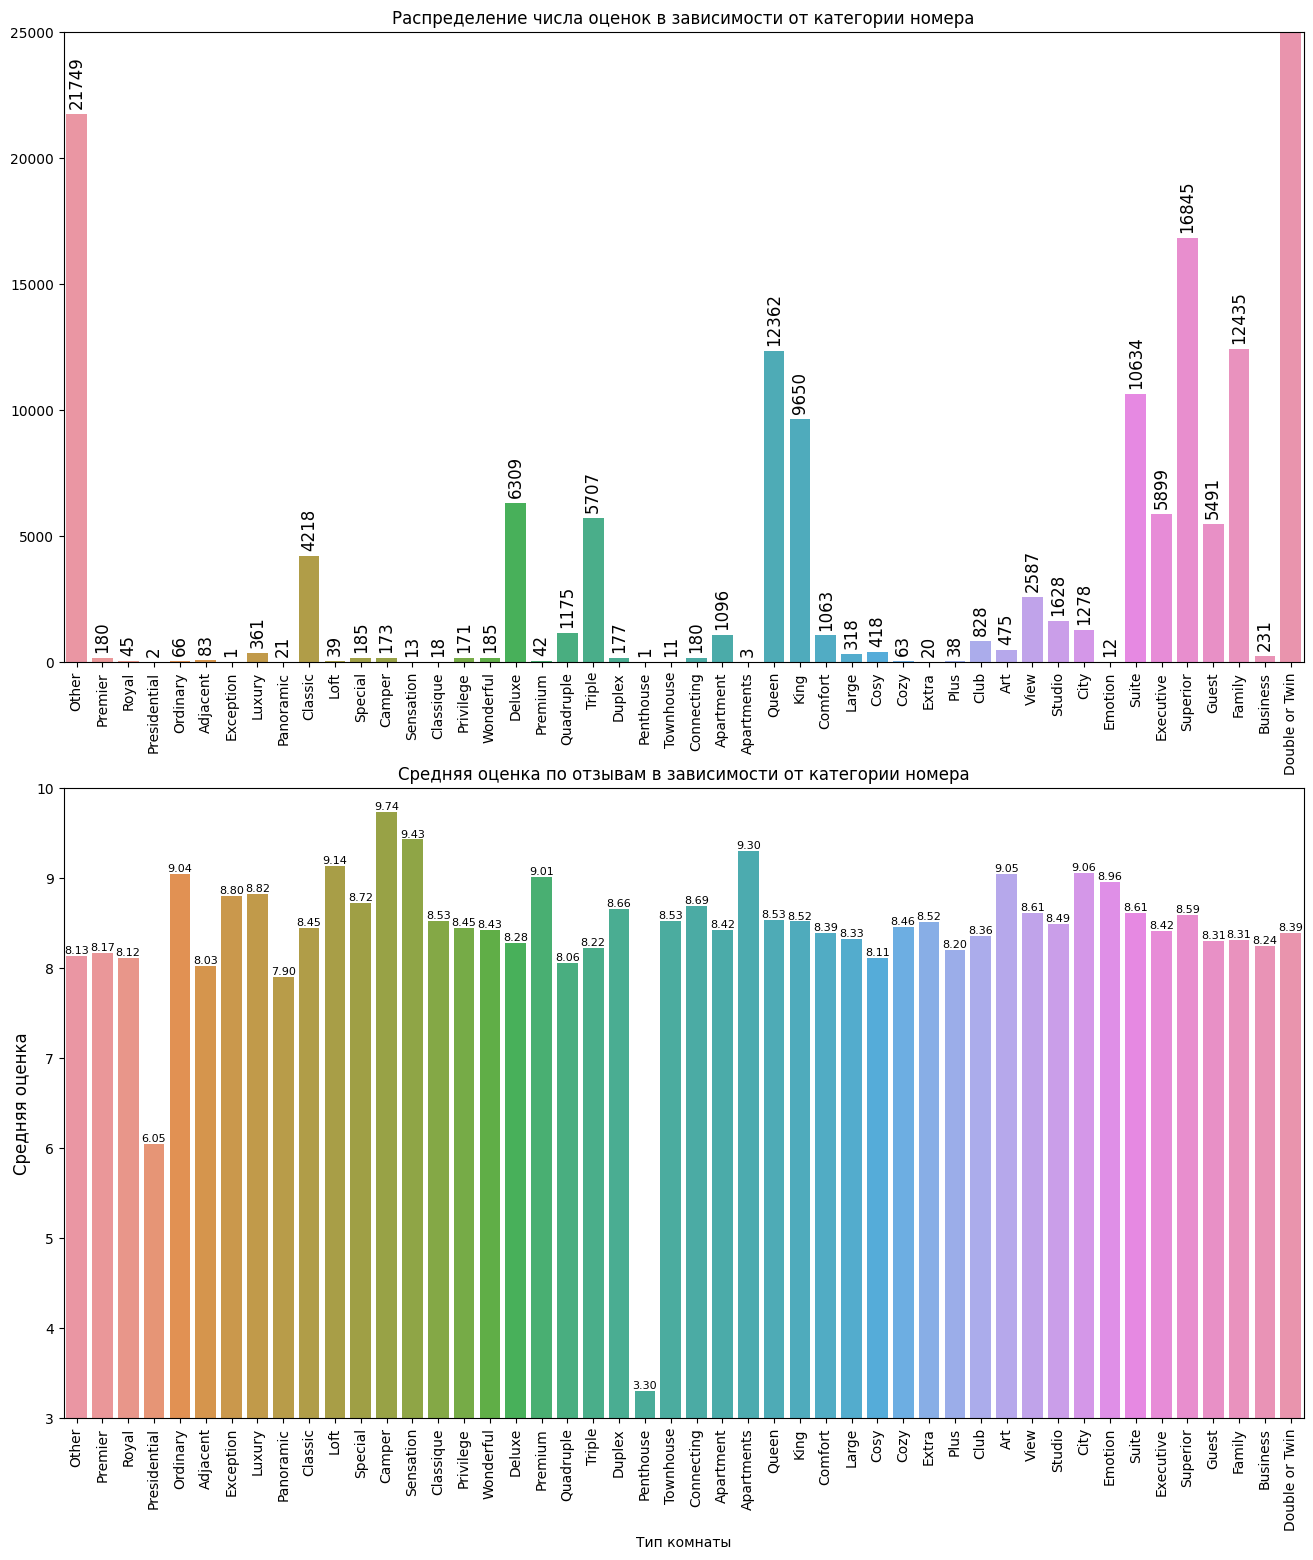

In [121]:
# сводная таблица для визуализации различия в оценках туристов, в зависимости от типа номера
pivot_types = pd.pivot_table(data[sample_mask], 
    index='tag_room_type', 
    values='reviewer_score', 
    aggfunc=['count', 'mean'])

# заготовка списка меток названий помещений для графика
# ===================================================================
# убираем НЕНАЙДЕННЫЕ теги
missed_room_types = [3, 12, 13] # тип помещений не найденных парсером

# собираем в упорядоченный словарь
room_type_ord_dict = OrderedDict(
    (k, v) 
    for k, v in sorted(room_types.items(), key = lambda x: x[1]) 
        if v not in missed_room_types
)

# забираем ключи от пар
room_type_list = list(room_type_ord_dict.keys())

# добавляем исключение вручную
room_type_list.append('Double or Twin')
# ===================================================================

# строим графики
fig, ax = plt.subplots(2, 1, figsize = (16, 18))
bar_types_1 = sns.barplot(
    x=pivot_types.index, 
    y=pivot_types[('count', 'reviewer_score')],
    ax=ax[0]
)

# задаём параметры осей
ax[0].set(ylabel = None, xlabel = None, title = 'Распределение числа оценок в зависимости от категории номера')
ax[0].set_xticklabels(room_type_list)
ax[0].tick_params(axis = 'x', rotation = 90)

bar_types_2 = sns.barplot(
    x = pivot_types.index, 
    y = pivot_types[('mean', 'reviewer_score')], 
    ax = ax[1]
)

# задаём параметры осей
ax[1].set(xlabel = 'Тип комнаты', title = 'Средняя оценка по отзывам в зависимости от категории номера')
ax[1].set_xticklabels(room_type_list)
ax[1].set_ylabel('Средняя оценка', fontsize = 12)
ax[1].tick_params(axis = 'x', rotation = 90)

# выравниваем подписи баров
for p in bar_types_1.patches:
    bar_types_1.annotate(
        '{:.0f}'.format(p.get_height()), (p.get_x() + 0.4, p.get_height() + 200),
        ha = 'center', 
        va = 'bottom', 
        rotation = 90,
        fontsize = 12
)

for p in bar_types_2.patches:
    bar_types_2.annotate(
        '{:.2f}'.format(p.get_height()), (p.get_x() + 0.4, p.get_height()),
        ha = 'center', 
        va = 'bottom', 
        fontsize = 8
)

# для bar_types_1 оценка по последней категории выступает за пределы 260к, 
# а значения количества оценок для некоторых остальных чрезвычайно малы
# задаём лимиты по оси ординат
bar_types_1.set_ylim(0, 25000)
bar_types_2.set_ylim(3, 10)
plt.show();

In [122]:
# смотрим, что получилось
data[['tag_from_mobile', 'tag_with_pet', 'tag_leisure_trip', 
        'tag_reviewer_type', 'tag_count_nights', 'tag_room_type', 'tag_view_room']].nunique()

tag_from_mobile       2
tag_with_pet          2
tag_leisure_trip      2
tag_reviewer_type     6
tag_count_nights     31
tag_room_type        48
tag_view_room         2
dtype: int64

In [123]:
# знакомимся с данными
data[['tag_from_mobile', 'tag_with_pet', 'tag_leisure_trip', 
        'tag_reviewer_type', 'tag_count_nights', 'tag_room_type', 'tag_view_room']].head()

,tag_from_mobile,tag_with_pet,tag_leisure_trip,tag_reviewer_type,tag_count_nights,tag_room_type,tag_view_room
0,0,0,1,2,2,50,0
1,0,0,1,6,1,23,0
2,1,0,0,1,1,50,0
3,0,0,1,2,1,44,0
4,1,0,0,1,2,50,0


In [124]:
# сверяемся с типом признаков
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 30 columns):
 #   Column                                      Non-Null Count   Dtype   
---  ------                                      --------------   -----   
 0   hotel_address                               515738 non-null  object  
 1   additional_number_of_scoring                515738 non-null  int64   
 2   review_date                                 515738 non-null  object  
 3   average_score                               515738 non-null  float64 
 4   hotel_name                                  515738 non-null  object  
 5   reviewer_nationality                        515738 non-null  object  
 6   negative_review                             515738 non-null  object  
 7   review_total_negative_word_counts           515738 non-null  int64   
 8   total_number_of_reviews                     515738 non-null  int64   
 9   positive_review                             515738 non-null

## 2.4. Преобразование признака '*reviewer_nationality*'

In [125]:
# удаляем "лишние" пробелы
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: x.strip())

# смотрим как распределяются национальности путешественников
data['reviewer_nationality'].value_counts(normalize = True).nlargest(30) * 100

United Kingdom              47.552439
United States of America     6.871124
Australia                    4.204848
Ireland                      2.874909
United Arab Emirates         1.984535
Saudi Arabia                 1.735571
Netherlands                  1.700864
Switzerland                  1.682637
Germany                      1.539735
Canada                       1.530622
France                       1.414672
Israel                       1.281659
Italy                        1.185486
Belgium                      1.169392
Turkey                       1.055575
Kuwait                       0.953973
Spain                        0.918490
Romania                      0.882619
Russia                       0.756198
South Africa                 0.740880
India                        0.666424
Greece                       0.660413
China                        0.659249
Sweden                       0.653045
New Zealand                  0.627644
Singapore                    0.599335
Hong Kong   

In [126]:
# оставляем только 25 наиболее путешествующих национальностей
top_25_tourist_nations = data['reviewer_nationality'].value_counts().nlargest(25).index
data['reviewer_nationality'] = data['reviewer_nationality'].apply(
    lambda x:x if x in top_25_tourist_nations else 'Other')
data['reviewer_nationality'].value_counts(normalize = True) * 100

United Kingdom              47.552439
Other                       14.696997
United States of America     6.871124
Australia                    4.204848
Ireland                      2.874909
United Arab Emirates         1.984535
Saudi Arabia                 1.735571
Netherlands                  1.700864
Switzerland                  1.682637
Germany                      1.539735
Canada                       1.530622
France                       1.414672
Israel                       1.281659
Italy                        1.185486
Belgium                      1.169392
Turkey                       1.055575
Kuwait                       0.953973
Spain                        0.918490
Romania                      0.882619
Russia                       0.756198
South Africa                 0.740880
India                        0.666424
Greece                       0.660413
China                        0.659249
Sweden                       0.653045
New Zealand                  0.627644
Name: review

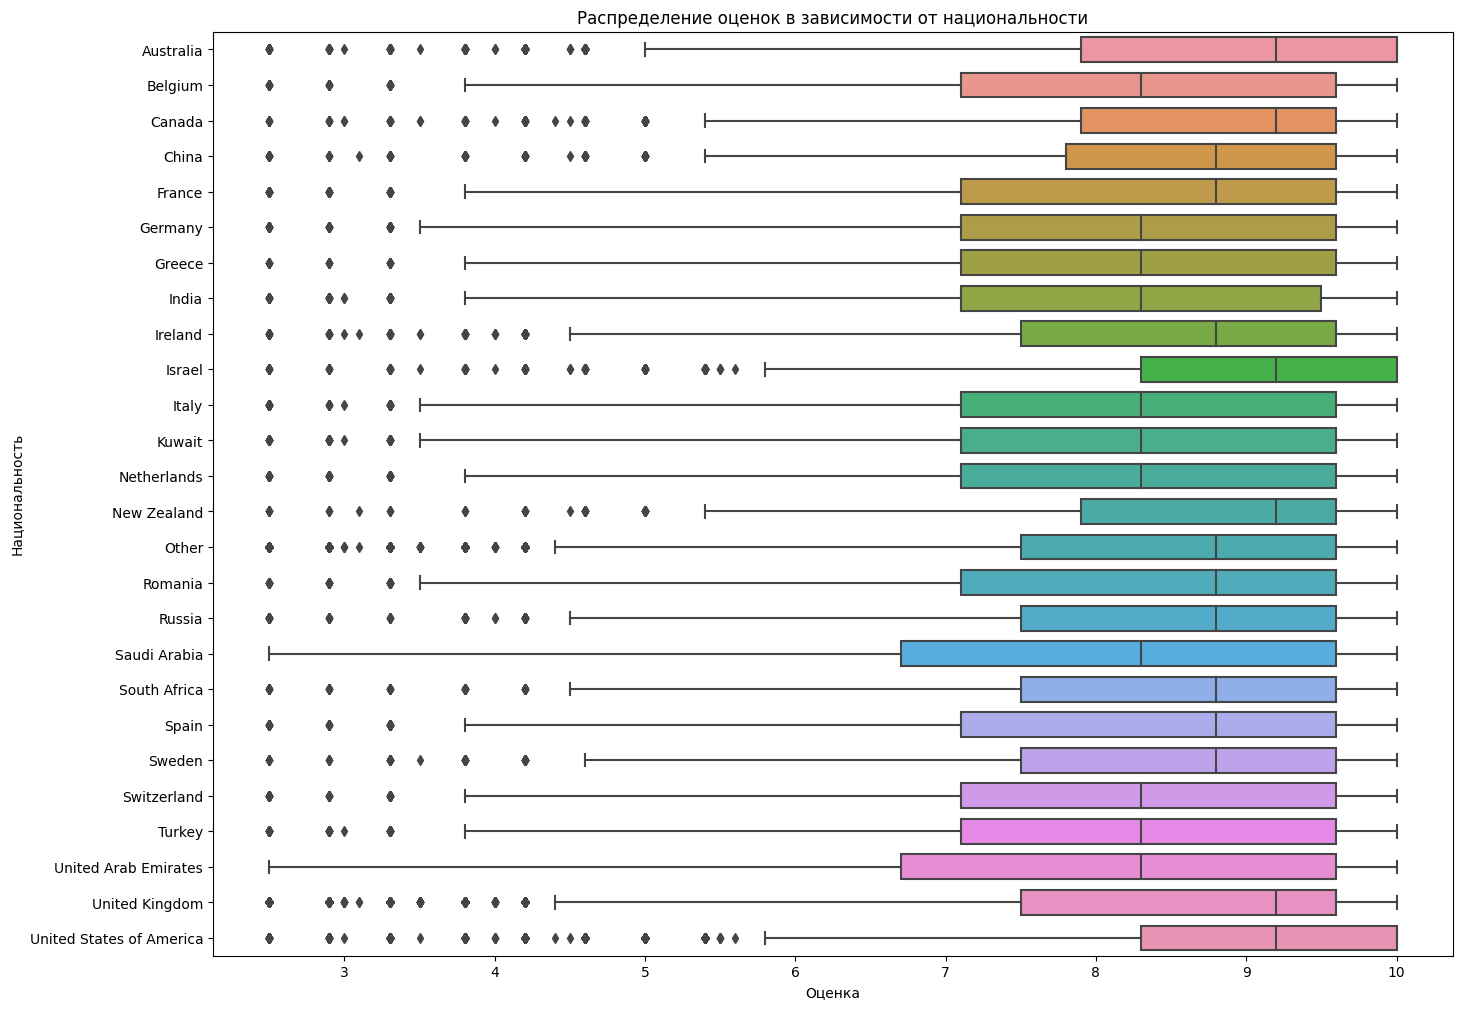

In [127]:
# посмотрим зависит ли оценка от национальности
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (16, 12))

# строим график
nationality = sns.boxplot(
    data = data[sample_mask].sort_values(by = 'reviewer_nationality', ascending = True),
    y = 'reviewer_nationality',
    x = 'reviewer_score',
    orient = 'h',
    width = 0.7
)

# задаём названия осей и заголовок
nationality.set(xlabel = 'Оценка', ylabel = 'Национальность', title = 'Распределение оценок в зависимости от национальности');

Наибольший диапазон оценок у Саудовской Аравии и ОАЭ.<br>
Наивысшая медиана оценок у Великобритании, США, Канады и Австралии.

Так как есть связь между оценкой рецензента и национальностью, то применим кодирование **Target Encoding**, таким кодированием сформируем "веса" признака '*reviewer_nationality*' в зависимости от оценки рецензента. Параметры кодировщика использованы стандартные, по умолчанию.

In [128]:
# кодируем признак
data['reviewer_nationality'] = data['reviewer_nationality'].astype('category')
reviewer_nationality_te = ce.TargetEncoder(
    min_samples_leaf=20, smoothing=10).fit_transform(
        data['reviewer_nationality'], data['reviewer_score'])

# переименовываем признак для удобства "отсева"
reviewer_nationality_te.rename(columns = {'reviewer_nationality': 'reviewer_nationality_te'}, inplace = True)
data = pd.concat([data, reviewer_nationality_te], axis = 1)

In [129]:
data[['reviewer_nationality', 'reviewer_nationality_te']]

,reviewer_nationality,reviewer_nationality_te
0,United Kingdom,6.369877
1,Belgium,6.130857
2,Sweden,6.230374
3,United States of America,6.578125
4,United Kingdom,6.369877
...,...,...
515733,France,6.189515
515734,Turkey,6.028747
515735,Netherlands,6.128055
515736,United Arab Emirates,5.872975


## 2.5. Преобразование признака '*review_date*'

In [130]:
# 'review_date' переводим в формат datetime64
data['review_date'] = pd.to_datetime(data['review_date'], yearfirst = True)

# создаём новый признак 'год-месяц'
data['year_month'] = data['review_date'].dt.to_period("M")

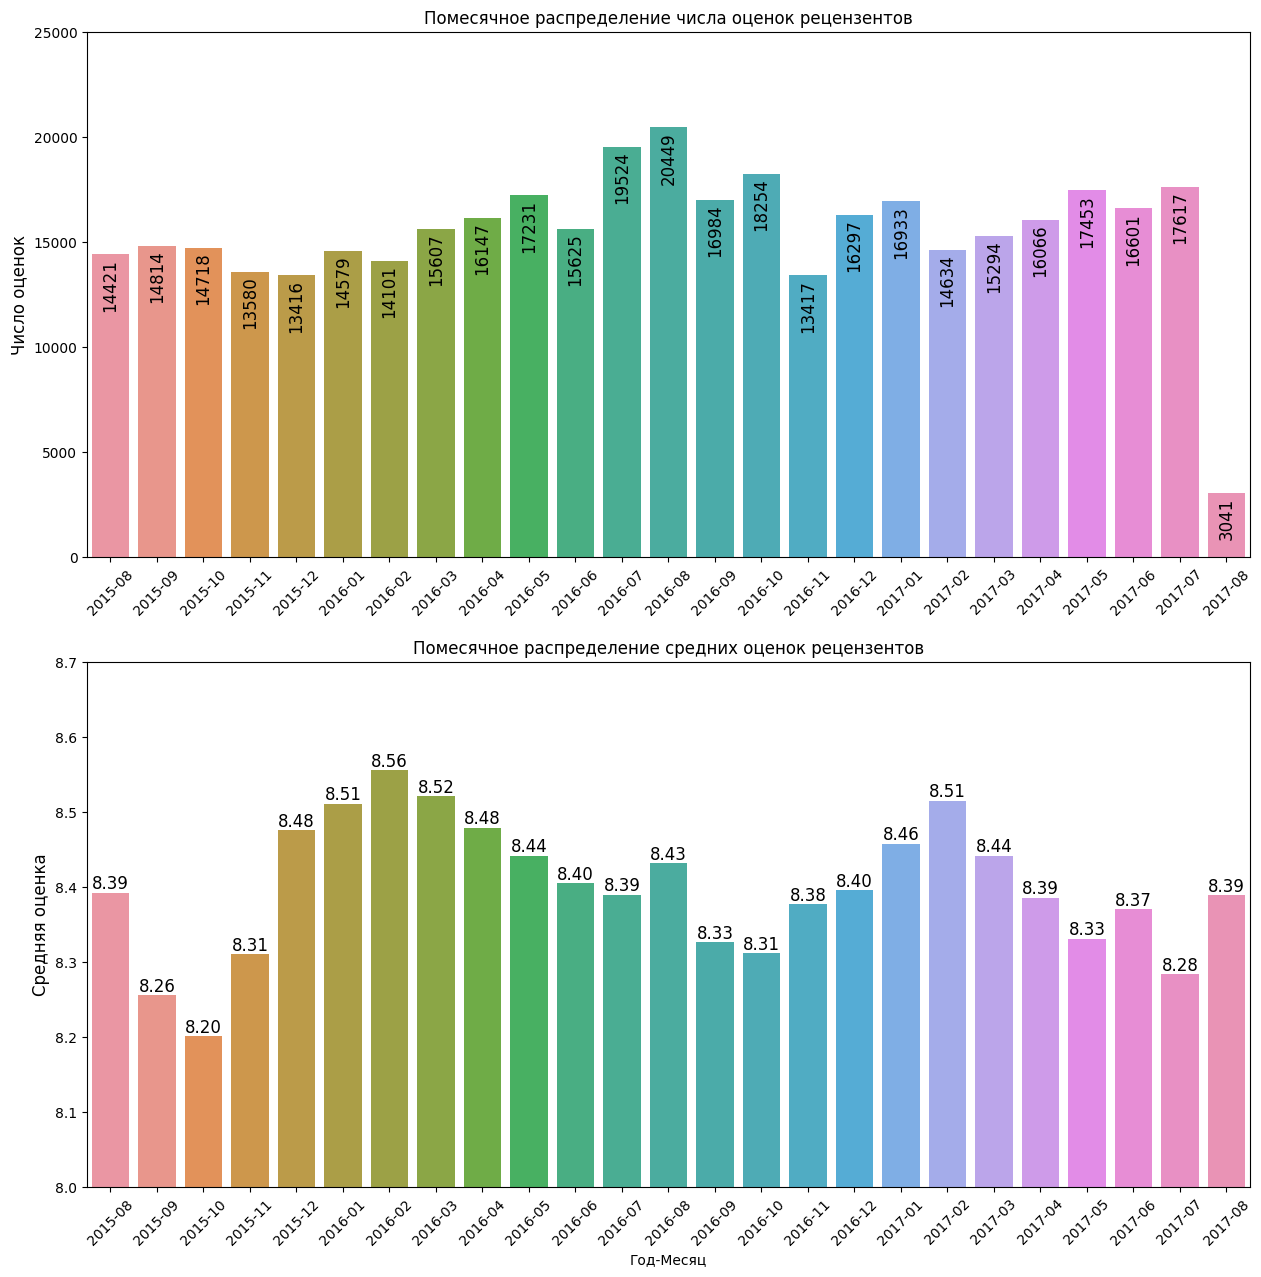

In [131]:
# сводная помесячная таблица для визуализации разницы средних оценок рецензентов
period = data[data['sample'] == 1].pivot_table(
    values = 'reviewer_score',
    index = 'year_month',
    aggfunc = ['mean', 'count']
)

# строим график
fig, ax = plt.subplots(2, 1, figsize = (15, 15))
bar_period_1 = sns.barplot(
    x = period.index, 
    y = period[('count', 'reviewer_score')], 
    ax = ax[0]
)
ax[0].set(xlabel=None, title='Помесячное распределение числа оценок рецензентов')
ax[0].set_ylabel('Число оценок', fontsize = 12)
ax[0].tick_params(axis = 'x', rotation = 45)

bar_period_2 = sns.barplot(
    x = period.index, 
    y = period[('mean', 'reviewer_score')], 
    ax = ax[1]
)
ax[1].set(xlabel = 'Год-Месяц', title = 'Помесячное распределение средних оценок рецензентов')
ax[1].set_ylabel('Средняя оценка', fontsize = 12)
ax[1].tick_params(axis = 'x', rotation = 45)

# выравниваем подписи баров
for p in bar_period_1.patches:
    bar_period_1.annotate(
        '{:.0f}'.format(p.get_height()), (p.get_x() + 0.4, p.get_height() - 200),
        ha = 'center', 
        va = 'top', 
        rotation = 90,
        fontsize = 12
)

for p in bar_period_2.patches:
    bar_period_2.annotate(
        '{:.2f}'.format(p.get_height()), (p.get_x() + 0.4, p.get_height()),
        ha = 'center', 
        va = 'bottom', 
        fontsize = 12
)

# задаём лимиты по оси ординат
bar_period_1.set_ylim(0, 25000)
bar_period_2.set_ylim(8, 8.7)
plt.show();

Так как есть связь между оценкой рецензента и сезонностью, это минимум 4 месяца в году, то применим кодирование **Target Encoding**, таким кодированием сформируем "веса" признака '*review_date*' в зависимости от оценки рецензента. Параметры кодировщика использованы стандартные, по умолчанию.

In [132]:
# кодируем признак 'year_month'
data['year_month'] = data['year_month'].astype('category')
period_te = ce.TargetEncoder(
    min_samples_leaf = 20, smoothing = 10).fit_transform(
        data['year_month'], data['reviewer_score']
)

# переименовываем признак для удобства "отсева"
period_te.rename(columns = {'year_month': 'year_month_te'}, inplace = True)
data = pd.concat([data, period_te], axis = 1)

In [133]:
# смотрим, что получилось
data[['year_month', 'year_month_te']]

,year_month,year_month_te
0,2017-07,6.227448
1,2016-12,6.310881
2,2015-11,6.249967
3,2015-10,6.194355
4,2016-05,6.304499
...,...,...
515733,2017-04,6.294678
515734,2017-02,6.385457
515735,2016-02,6.398011
515736,2017-05,6.208587


## 2.6. Преобразование признака '*days_since_review*'

In [134]:
# из признака 'days_since_review' выделим число, удалив слова day(s), меняем тип данных на int
data['days_since_review'] = data['days_since_review'].apply(
    lambda x: int(re.findall(r'\d+', x)[0])).astype('int16')

In [135]:
# смотрим, что получилось
data['days_since_review']

0          13
1         234
2         616
3         656
4         444
         ... 
515733    106
515734    171
515735    543
515736     74
515737    363
Name: days_since_review, Length: 515738, dtype: int16

In [136]:
# сверяемся с типом признаков
data['days_since_review'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 515738 entries, 0 to 515737
Series name: days_since_review
Non-Null Count   Dtype
--------------   -----
515738 non-null  int16
dtypes: int16(1)
memory usage: 1007.4 KB


In [137]:
data['days_since_review'].max()

730

## 2.7. Преобразование признака '*hotel_name*'

In [138]:
# собираем сводную таблицу с уникальным числом имён отелей и адресами
pivot_name_addr = data[['hotel_address', 'hotel_name']].groupby(
    by = 'hotel_name').nunique()

# отсеиваем отели с именами-дубликатами
mask_hotel_name = pivot_name_addr['hotel_address'] != 1
hotel_name_dupl = pivot_name_addr[mask_hotel_name].index.to_list()

# выводим число отелей с именами-дубликатами
mask_name_dupl = data['hotel_name'].isin(hotel_name_dupl)
hotel_addr_dupl = data[mask_name_dupl][['hotel_name', 'hotel_address']].value_counts()
hotel_addr_dupl

hotel_name    hotel_address                                             
Hotel Regina  Bergara 2 4 Eixample 08002 Barcelona Spain                    590
              Rooseveltplatz 15 09 Alsergrund 1090 Vienna Austria           284
              Via Cesare Correnti 13 Milan City Center 20123 Milan Italy     60
dtype: int64

In [139]:
# модифицируем названия отелей, добавив в название город
data['hotel_name'] = data.apply(
    lambda row: (row['hotel_name'] + ' ' + row['hotel_address'].split()[-2])
    if (row['hotel_name'] in hotel_name_dupl)
    else row['hotel_name'], axis = 1)

# смотрим, что получилось
mask = data['hotel_name'].str.contains(hotel_name_dupl[0])
data[mask]['hotel_name'].value_counts()

Hotel Regina Barcelona    590
Hotel Regina Vienna       284
Hotel Regina Milan         60
Name: hotel_name, dtype: int64

In [140]:
# кодируем hotel_name - признак не совсем информативный, просто его не стоит удалять - по нему группируются отзывы
data['hotel_name'] = data['hotel_name'].astype('category')
data['hotel_name_code'] = data['hotel_name'].cat.codes

In [141]:
# смотрим, что получилось
data['hotel_name_code']

0          612
1         1447
2           33
3          735
4          633
          ... 
515733     711
515734     104
515735     177
515736    1366
515737    1373
Name: hotel_name_code, Length: 515738, dtype: int16

## 2.8. Преобразование признаков '*negative_review*', '*positive_review*'

* Осталось как то обработать 'negative_review','positive_review'.
* Тут я использую Анализ настроений с помощью SentimentIntensityAnalyzer библиотеки VADER.
* Его в этом проекте многие используют. 

In [142]:
# удаляем начальные и конечные пробелы в признаке негативных отзывов
data['negative_review'] = data['negative_review'].apply(lambda x: x.strip())
data['negative_review'].value_counts().reset_index().head(25)

,index,negative_review
0,No Negative,127890
1,Nothing,18531
2,nothing,2508
3,None,1166
4,N A,1060
5,,849
6,Nothing really,570
7,N a,520
8,All good,470
9,Small room,455


In [143]:
# удаляем начальные и конечные пробелы в признаке позитивных отзывов
data['positive_review'] = data['positive_review'].apply(lambda x: x.strip())
data['positive_review'].value_counts().reset_index().head(25)

,index,positive_review
0,No Positive,35946
1,Location,10137
2,Everything,2897
3,location,1736
4,Nothing,1468
5,Great location,1419
6,The location,1341
7,Good location,1203
8,Breakfast,664
9,Friendly staff,603


In [144]:
%%time

# корректируем явные выражения 
data['negative_review'] = data['negative_review'].apply(lambda x: x.replace('No Negative', 'Positive'))
data['negative_review'] = data['negative_review'].apply(lambda x: x.replace('N A', 'Positive'))
data['negative_review'] = data['negative_review'].apply(lambda x: x.replace('All good', 'Positive'))
data['negative_review'] = data['negative_review'].apply(lambda x: x.replace('No complaints', 'Positive'))
data['negative_review'] = data['negative_review'].apply(lambda x: x.replace('Nothing to dislike', 'Positive'))
data['positive_review'] = data['positive_review'].apply(lambda x: x.replace('No Positive', 'Negative'))

# создаем два экземпляра анализатора, чтобы разделить лексикон 
# для разной системы оценки положительных и отрицательных отзывов
sia_neg = SentimentIntensityAnalyzer()
sia_pos = SentimentIntensityAnalyzer()

# добавим контекст, чтобы "No Negative" тонально нёс негативную окраску
neg_words = {'small': -1, 'nothing': 10}
pos_words = {'nothing': -10, 'everything': 10}
sia_neg.lexicon.update(neg_words)
sia_pos.lexicon.update(pos_words)

data['neg_scores'] = data['negative_review'].apply(lambda x: sia_neg.polarity_scores(x))
data['pos_scores'] = data['positive_review'].apply(lambda x: sia_pos.polarity_scores(x))

# формируем новые признаки
data['n_review_sentiments_neg'] = data['neg_scores'].apply(lambda x: x['neg'])
data['n_review_sentiments_neu'] = data['neg_scores'].apply(lambda x: x['neu'])
data['n_review_sentiments_pos'] = data['neg_scores'].apply(lambda x: x['pos'])
data['n_review_sentiments_compound'] = data['neg_scores'].apply(lambda x: x['compound'])

data['p_review_sentiments_neg'] = data['pos_scores'].apply(lambda x: x['neg'])
data['p_review_sentiments_neu'] = data['pos_scores'].apply(lambda x: x['neu'])
data['p_review_sentiments_pos'] = data['pos_scores'].apply(lambda x: x['pos'])
data['p_review_sentiments_compound'] = data['pos_scores'].apply(lambda x: x['compound'])

CPU times: total: 6min 4s
Wall time: 9min 34s


In [145]:
# сверяемся с типом признаков
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 44 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               515738 non-null  object        
 1   additional_number_of_scoring                515738 non-null  int64         
 2   review_date                                 515738 non-null  datetime64[ns]
 3   average_score                               515738 non-null  float64       
 4   hotel_name                                  515738 non-null  category      
 5   reviewer_nationality                        515738 non-null  category      
 6   negative_review                             515738 non-null  object        
 7   review_total_negative_word_counts           515738 non-null  int64         
 8   total_number_of_reviews                     515738 non-null  int64        

## 2.9. Преобразование признаков '*review_total_negative_word_counts*', '*review_total_positive_word_counts*'

Целевая переменная демонстрирует зависимость от обеих величин. Соединим оба признака в один, вычислив разницу количества слов в позитивной и негативной частях отзыва, предварительно нормализуем оба признака:

In [146]:
# кодируем исходный признак
data_ttl_pos_words_cnts_mm = preprocessing.MinMaxScaler().fit_transform(
    data[['review_total_positive_word_counts']])
data_ttl_neg_words_cnts_mm = preprocessing.MinMaxScaler().fit_transform(
    data[['review_total_negative_word_counts']])

# преобразуем промежуточный датасет в полноценный датафрейм для визуализации
data_ttl_pos_words_cnts_mm = pd.DataFrame(
    data_ttl_pos_words_cnts_mm, columns=['review_ttl_pos_word_cnts_norm'])
data_ttl_neg_words_cnts_mm = pd.DataFrame(
    data_ttl_neg_words_cnts_mm, columns=['review_ttl_neg_word_cnts_norm'])

# посмотреть результаты
# display(data_ttl_pos_words_cnts_mm, data_ttl_neg_words_cnts_mm)

# добавляем к основному датасету
data = pd.concat([data, data_ttl_pos_words_cnts_mm], axis = 1)
data = pd.concat([data, data_ttl_neg_words_cnts_mm], axis = 1)

# соединим эти показатели в один - разностный
data['review_ttl_word_cnts_diff_norm'] = data['review_ttl_pos_word_cnts_norm'] - \
    data['review_ttl_neg_word_cnts_norm']

# добавим флаг, который показывает преобладают ли позитивные слова 
# над негативными в размерностях соответствующих диапазонов
data['more_positive_words_flag'] = data['review_ttl_word_cnts_diff_norm'].apply(
    lambda x: 1 if x >= 0 else 0).astype('int8')

Также добавим долю одной из частей (второй показатель будет обратно пропорциональным):

In [147]:
# формируем новый дополнительный признак из числа основных
data['review_total_word_counts'] = data['review_total_positive_word_counts'] + \
    data['review_total_negative_word_counts']

# если общее количество слов равно 0, то считаем обе части равнозначными - по 0.5
data['review_positive_word_proportion'] = data.apply(
    lambda x: 0.5 if x['review_total_word_counts'] == 0 \
        else (x['review_total_positive_word_counts'] / x['review_total_word_counts']),
    axis = 1)

# удаление вспомогательных дополнительных признаков
data.drop(['review_ttl_pos_word_cnts_norm', 
    'review_ttl_neg_word_cnts_norm', 
    'review_ttl_word_cnts_diff_norm',
    'review_total_word_counts'], axis = 1, inplace = True)

In [148]:
# проверка результата
data[['more_positive_words_flag', 'review_positive_word_proportion']]

,more_positive_words_flag,review_positive_word_proportion
0,1,0.543860
1,0,0.000000
2,1,0.625000
3,1,1.000000
4,1,1.000000
...,...,...
515733,1,1.000000
515734,1,1.000000
515735,0,0.428571
515736,1,1.000000


## 2.10. Преобразование признака '*total_number_of_reviews_reviewer_has_given*'

In [149]:
# вычисляем долю рецензий данных рецензентом от общего числа отзывов в датасете
data['ratio_of_review'] = data['total_number_of_reviews_reviewer_has_given'] / \
    data['total_number_of_reviews']

# логарифмируем значение признака, чтобы оставить только информацию о степени (порядке) активности рецензента
data['total_number_of_reviews_reviewer_has_given'] = data['total_number_of_reviews_reviewer_has_given'].apply(
    lambda x: np.log(x + 1))

In [150]:
# проверка результата
data['ratio_of_review']

0         0.000060
1         0.001395
2         0.042735
3         0.005833
4         0.000427
            ...   
515733    0.016207
515734    0.000310
515735    0.007634
515736    0.017869
515737    0.001654
Name: ratio_of_review, Length: 515738, dtype: float64

# 3. Очистка и выбор признаков

## 3.1 Очистка датасета от исходных (и более не требующихся) признаков

Подготовим датасет к очистке признаков, на которых модель обучаться не будет

In [151]:
# сверяемся с типом признаков
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 47 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               515738 non-null  object        
 1   additional_number_of_scoring                515738 non-null  int64         
 2   review_date                                 515738 non-null  datetime64[ns]
 3   average_score                               515738 non-null  float64       
 4   hotel_name                                  515738 non-null  category      
 5   reviewer_nationality                        515738 non-null  category      
 6   negative_review                             515738 non-null  object        
 7   review_total_negative_word_counts           515738 non-null  int64         
 8   total_number_of_reviews                     515738 non-null  int64        

In [152]:
# создаем копию датафрейма (для повторного воспроизведения шагов с уже обработанными данными)
data_copy = data.__deepcopy__()

In [153]:
# # "включить машину времени для датафрейма"
# data = data_copy

In [154]:
# убираем нечисловые признаки, т.к. модель может обучаться только на числовых признаках
object_columns = [col for col in data.columns
    if ((data[col].dtypes == 'object') | \
        (data[col].dtype.name == 'category') | \
        (data[col].dtypes == 'datetime64[ns]'))]

# смотрим, что попадает под удаление
print(f'Удалению подлежит {len(object_columns)} столбцов с нечисловыми данными:')
object_columns

Удалению подлежит 12 столбцов с нечисловыми данными:


['hotel_address',
 'review_date',
 'hotel_name',
 'reviewer_nationality',
 'negative_review',
 'positive_review',
 'tags',
 'hotel_country',
 'hotel_city',
 'year_month',
 'neg_scores',
 'pos_scores']

In [155]:
# удаляем выбранные признаки по заданным критериям
data.drop(object_columns, axis = 1, inplace = True)

In [156]:
# сверяемся с типом признаков
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 35 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   review_total_negative_word_counts           515738 non-null  int64  
 3   total_number_of_reviews                     515738 non-null  int64  
 4   review_total_positive_word_counts           515738 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515738 non-null  float64
 6   days_since_review                           515738 non-null  int16  
 7   lat                                         515738 non-null  float64
 8   lng                                         515738 non-null  float64
 9   sample                                      515738 non-null  int64  
 

## 3.2 Анализ мультиколлинеарности

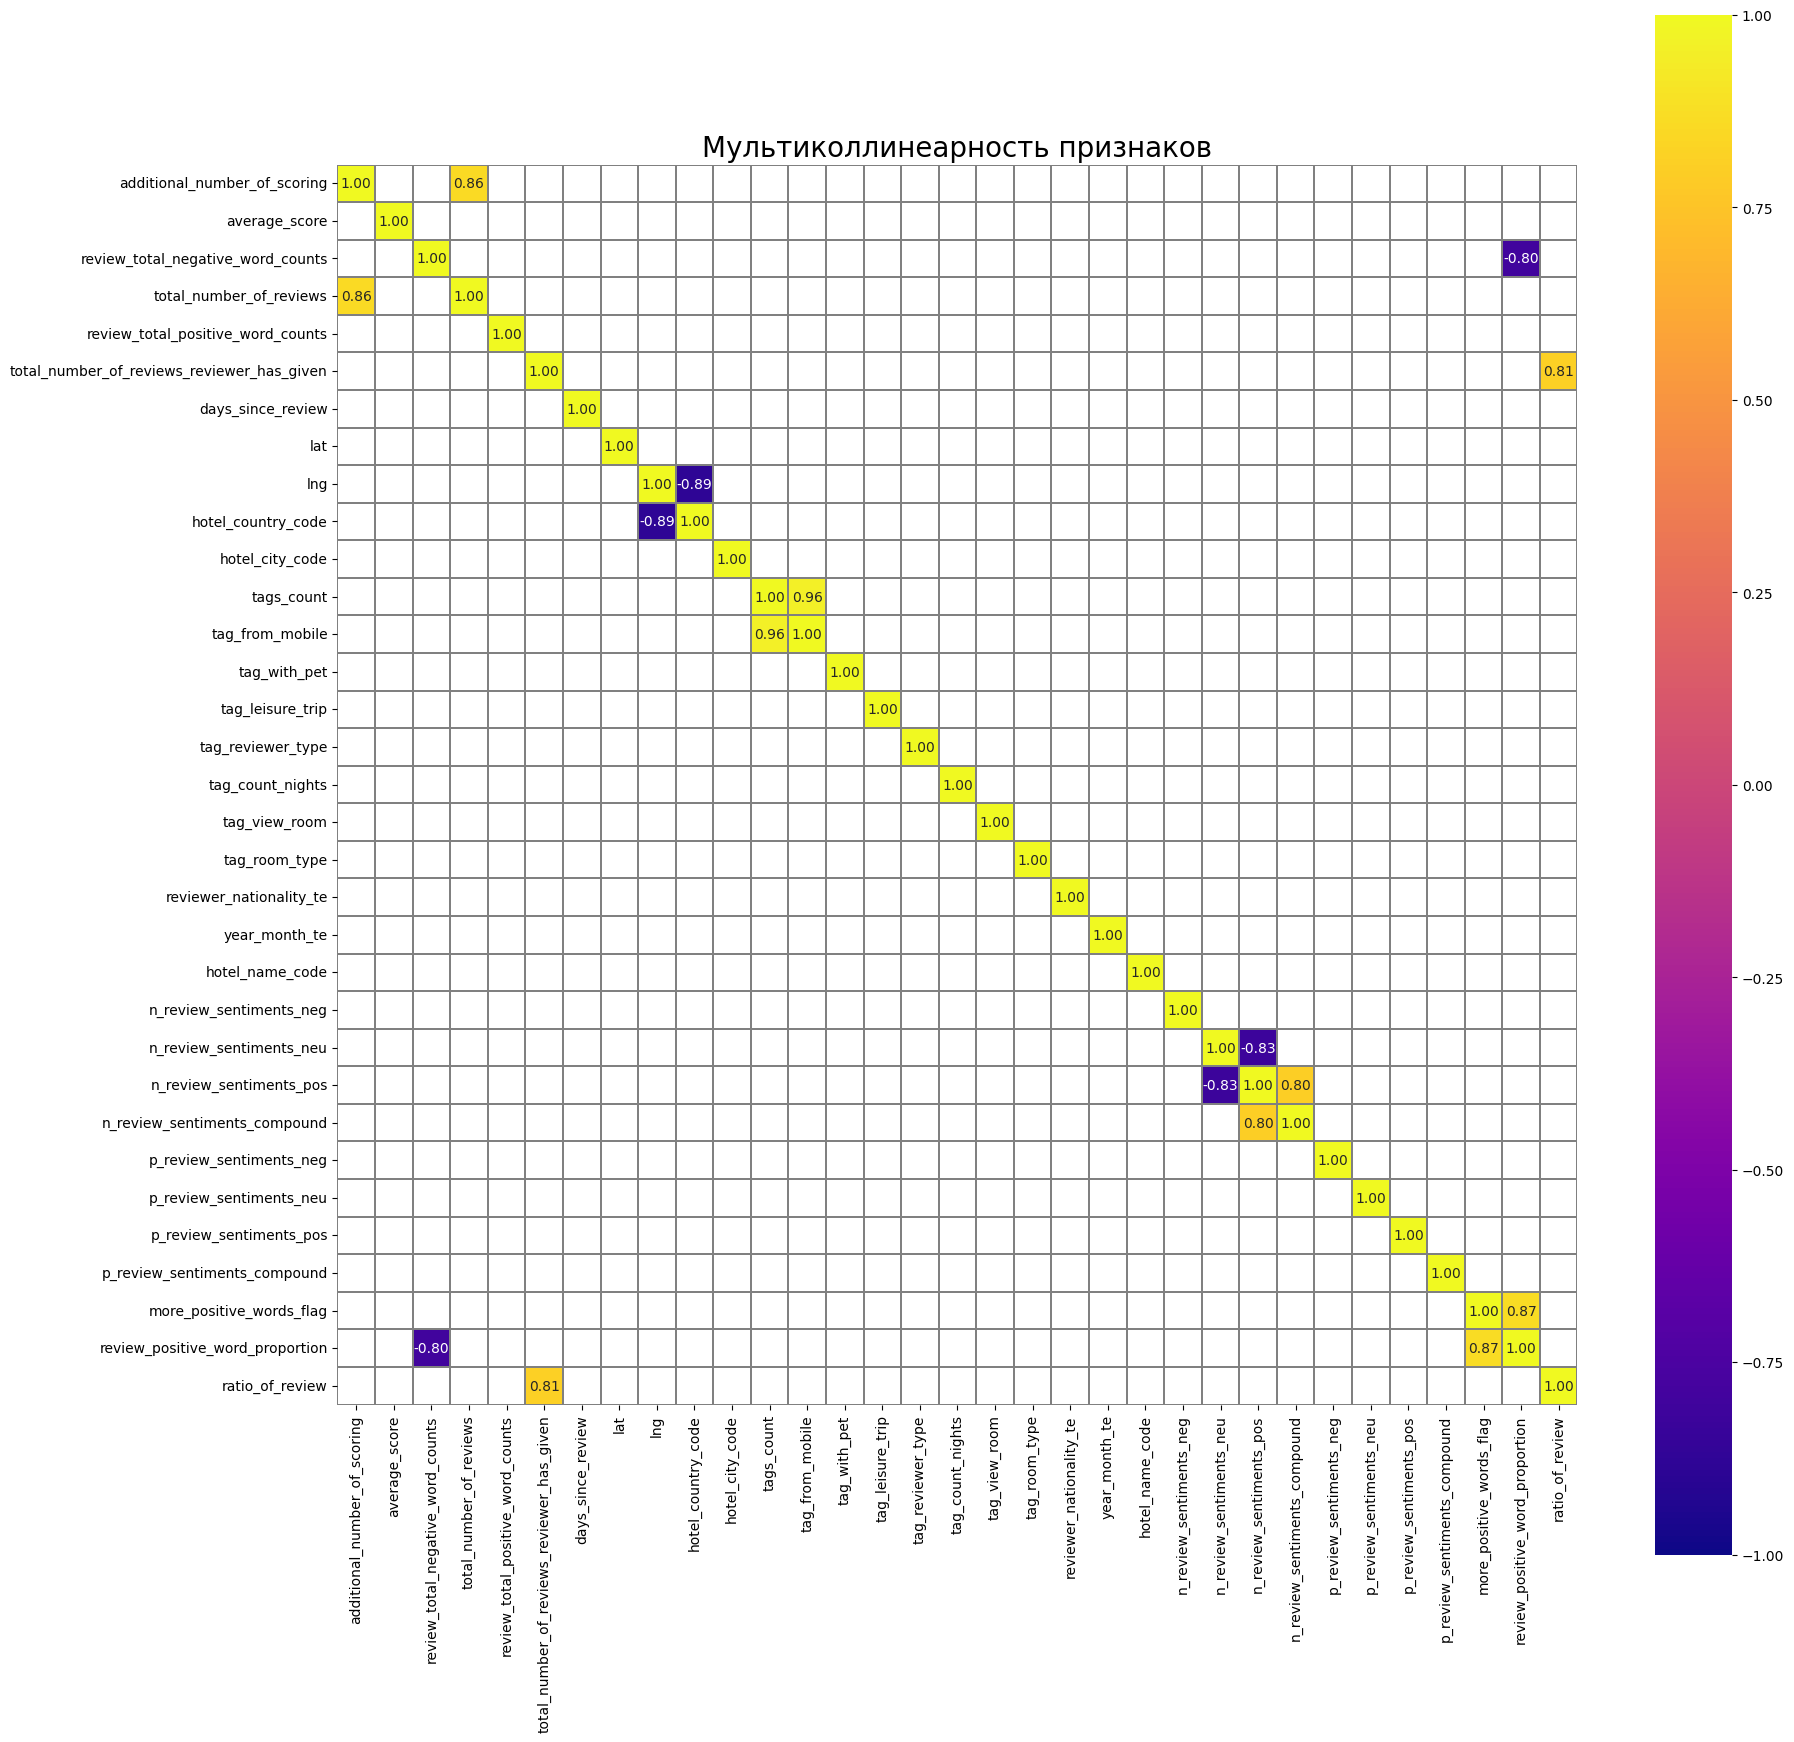

In [157]:
# строим тепловую корреляционную матрицу и анализируем данные на предмет наличия мультиколлинеарности
# используем метод Спирмана, т.к. у нас не только непрерывные переменные

# данные для построения графика
corr = data.drop(['sample', 'reviewer_score'], axis = 1).corr(method = 'spearman')
plt.subplots(figsize = (20, 20))

# график - тепловая матрица с коэффициентами корреляции не менее 0.7
ax_heat_multicoll = sns.heatmap(
    corr[corr.abs() >= 0.7], 
    vmin = -1, 
    vmax = 1, 
    linewidth = 0.1, 
    linecolor = 'gray', 
    cmap = 'plasma',
    annot = True,
    fmt = '.2f',
    square = True
)

# задаём заголовок
ax_heat_multicoll.set_title('Мультиколлинеарность признаков', fontsize = 20);

Исходя из представленной тепловой матрицы смело можно удалить:

* lat
* lng

Эти признаки ни на что не повлияют, а остальные стоит рассмотреть в разрезе оценки ANOVA и Хи-квадрат

## 3.3 Оценка значимости признаков

Для оценки значимости признаков будем использовать тесты:
* хи-квадрат — для **категориальных** 
* тест ANOVA — для **числовых** (непрерывных) признаков

In [158]:
# разделим признаки на 2 группы - категориальные и числовые
data.columns

Index(['additional_number_of_scoring', 'average_score',
       'review_total_negative_word_counts', 'total_number_of_reviews',
       'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given', 'days_since_review',
       'lat', 'lng', 'sample', 'reviewer_score', 'hotel_country_code',
       'hotel_city_code', 'tags_count', 'tag_from_mobile', 'tag_with_pet',
       'tag_leisure_trip', 'tag_reviewer_type', 'tag_count_nights',
       'tag_view_room', 'tag_room_type', 'reviewer_nationality_te',
       'year_month_te', 'hotel_name_code', 'n_review_sentiments_neg',
       'n_review_sentiments_neu', 'n_review_sentiments_pos',
       'n_review_sentiments_compound', 'p_review_sentiments_neg',
       'p_review_sentiments_neu', 'p_review_sentiments_pos',
       'p_review_sentiments_compound', 'more_positive_words_flag',
       'review_positive_word_proportion', 'ratio_of_review'],
      dtype='object')

In [159]:
# категориальные признаки
cat_cols = [
    'average_score',
    'reviewer_nationality_te', 
    
    'hotel_country_code', 
    'hotel_city_code', 
    'tag_from_mobile', 
    'tag_with_pet',
    'tag_leisure_trip', 
    'tag_reviewer_type', 
    'tag_count_nights', 
    'tag_view_room', 
    'tag_room_type', 
    'year_month_te', 
    'hotel_name_code', 

    'more_positive_words_flag'
]

# числовые (непрерывные) признаки
num_cols = [
    'additional_number_of_scoring', 
    'review_total_negative_word_counts', 
    'review_total_positive_word_counts', 
    'total_number_of_reviews_reviewer_has_given', 
    'total_number_of_reviews', 
    'days_since_review', 
    
    'tags_count', 
    
    'n_review_sentiments_neg', 'n_review_sentiments_neu',
    'n_review_sentiments_pos', 'n_review_sentiments_compound',
    'p_review_sentiments_neg', 'p_review_sentiments_neu',
    'p_review_sentiments_pos', 'p_review_sentiments_compound',
    
    'review_positive_word_proportion', 
    'ratio_of_review'
]

In [160]:
# разбиваем датасет на части, необходимые для оценки признаков
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)
X = data[sample_mask].drop(['reviewer_score'], axis = 1)
y = data[sample_mask]['reviewer_score'].astype('int')

In [161]:
# функция построения тепловой матрицы корреляции для группы признаков
def show_corr_heatmap(columns_list, method = 'pearson', title_heat = None):
    """ Функция строит тепловую матрицу корреляции по переданным параметрам,
        на выходе - график, никакие значения не возвращаются

    Args:
        columns_list (list): список признаков, для которых строится матрица корреляции
        method (str, optional): расчётный метод корреляции. Defaults to 'pearson'.
        title_heat (str, optional): заголовок графика. Defaults to None.
    """
    _, ax_heat = plt.subplots(figsize = (15, 15))
    # данные для построения графика
    corr = data[columns_list].corr(method = method)
    
    # задаём срезовую маску, выводятся параметры по нижней диагонали
    mask = np.triu(np.ones_like(corr, dtype = bool))
    
    # график - тепловая матрица
    sns.heatmap(
        corr,
        ax = ax_heat,
        vmin = -1, 
        vmax = 1, 
        mask = mask,
        linewidths = 0.1,
        annot = True,
        cmap = 'coolwarm',
        fmt = '.2f',
        square = True)
    
    # задаём заголовок и кегль начертания
    ax_heat.set_title(title_heat, fontsize = 20)
    plt.show()

### 3.3.1 Оценка значимости категориальных признаков

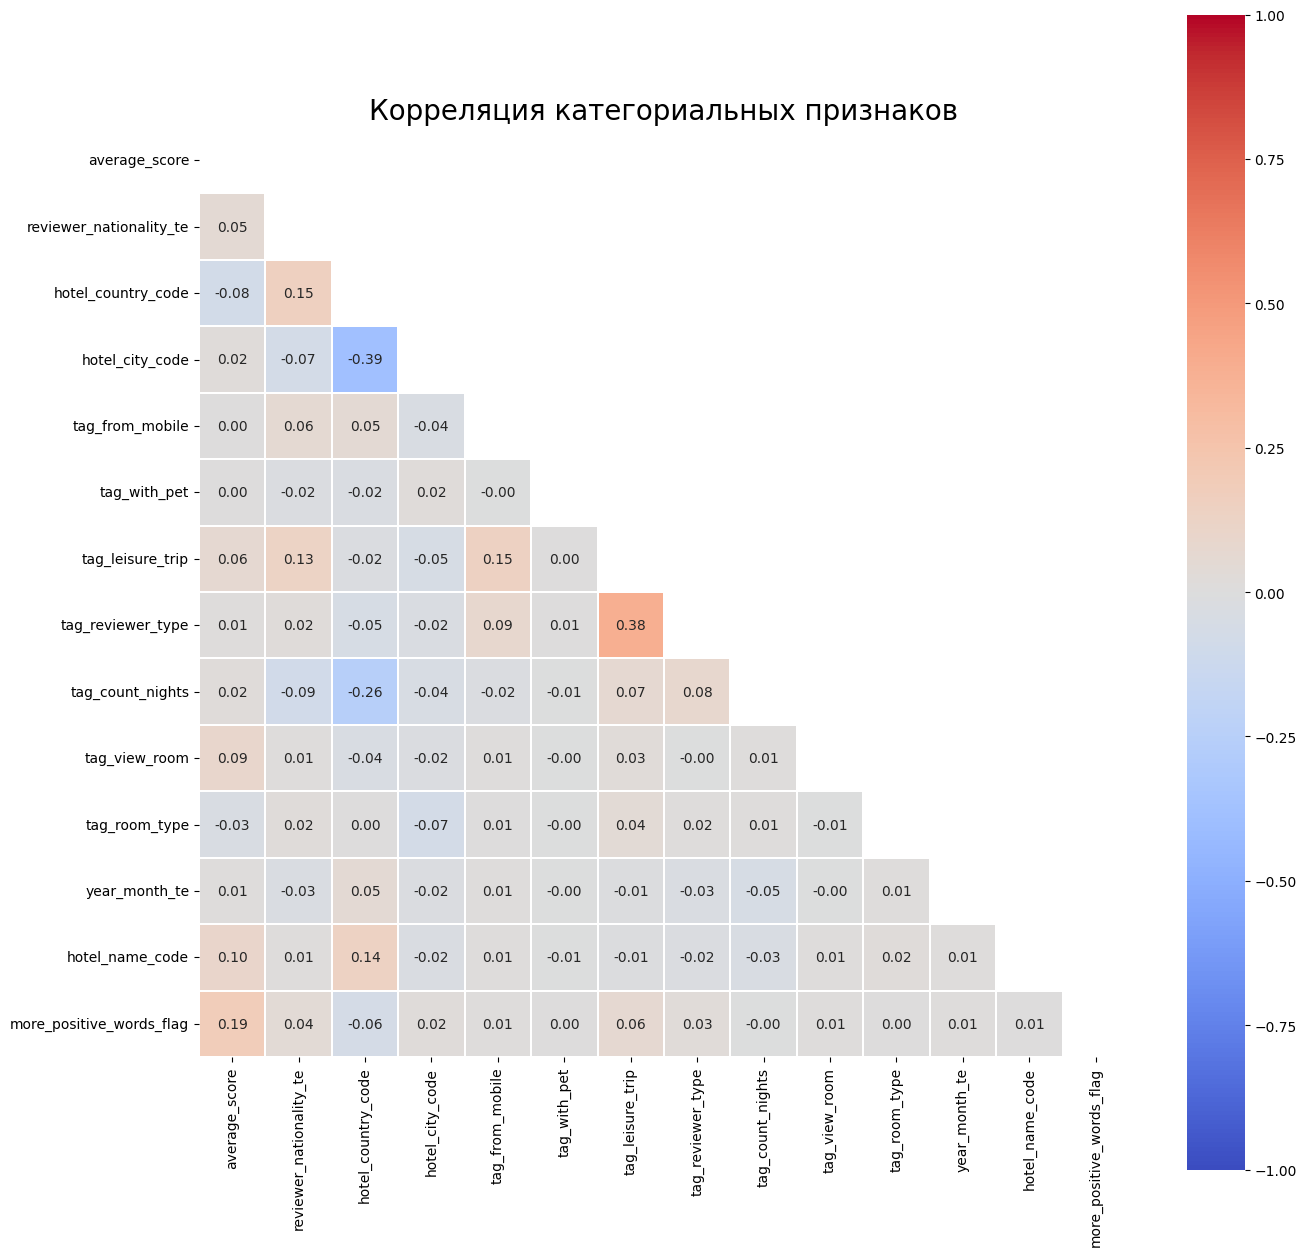

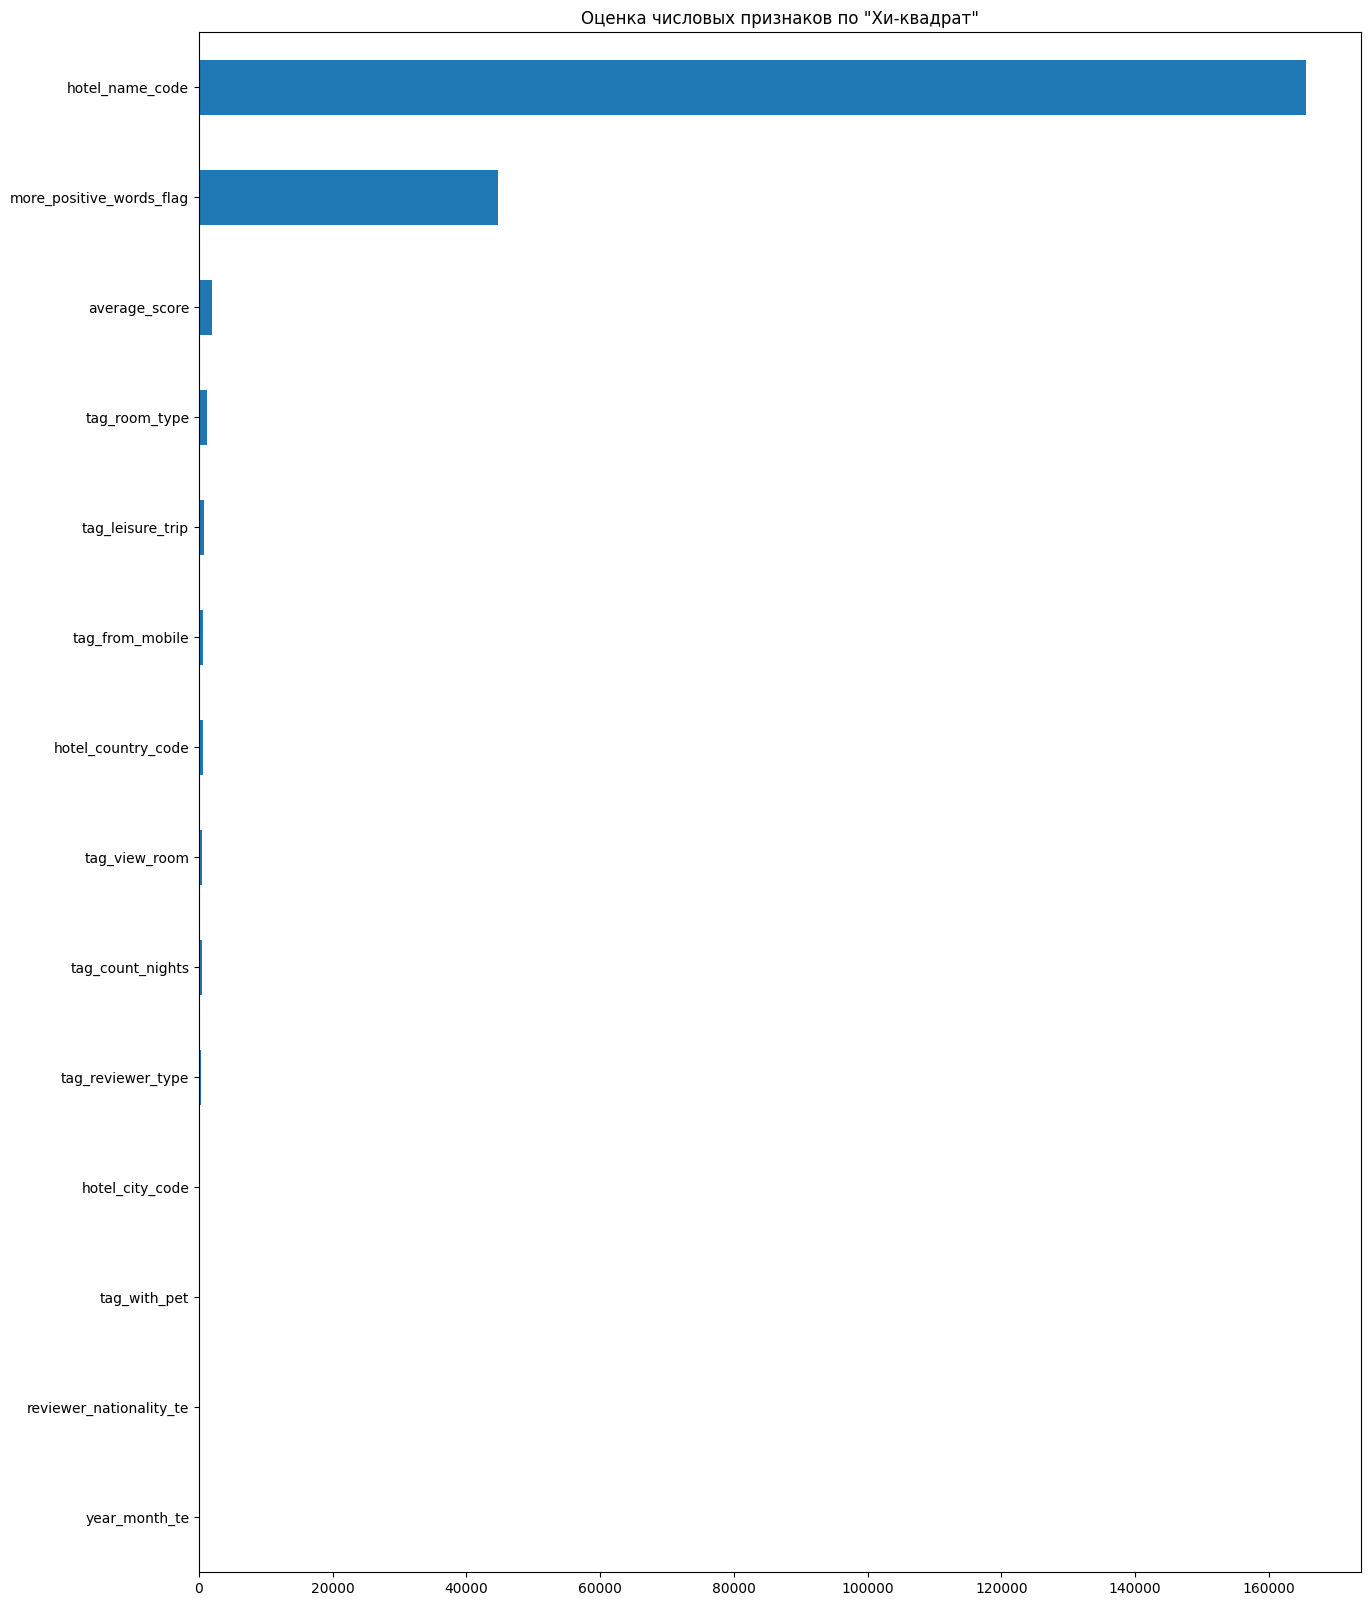

In [162]:
# графики категориальных признаков

# тепловая матрица категориальных признаков
show_corr_heatmap(
    cat_cols, 
    method = 'spearman',
    title_heat = 'Корреляция категориальных признаков'
)

# визуализируем результат анализа значимости
# столбчатая диаграмма категориальных признаков по "хи-квадрат"
imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index = cat_cols)
imp_cat.sort_values(inplace = True)
_, ax_barh_chi2 = plt.subplots(figsize = (15, 20))
imp_cat.plot(kind = 'barh', title = 'Оценка числовых признаков по "Хи-квадрат"');

### 3.3.2 Оценка значимости числовых признаков

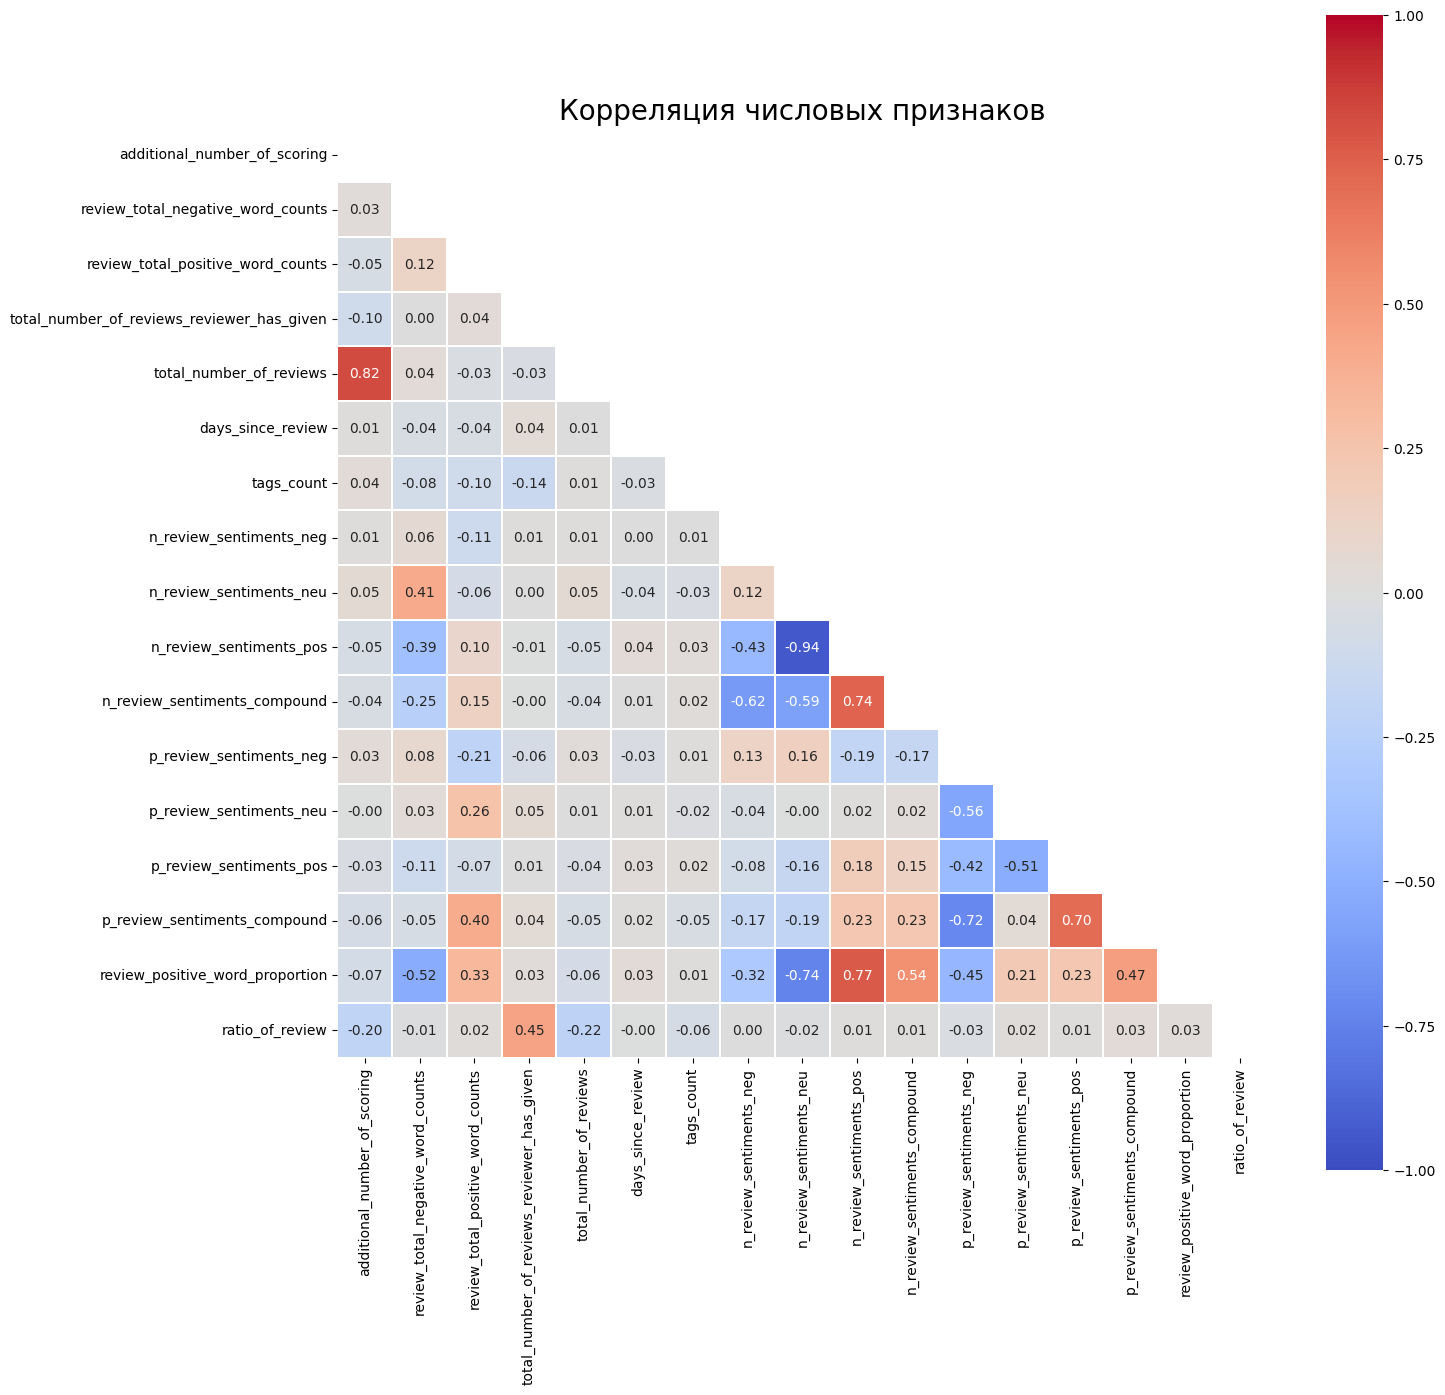

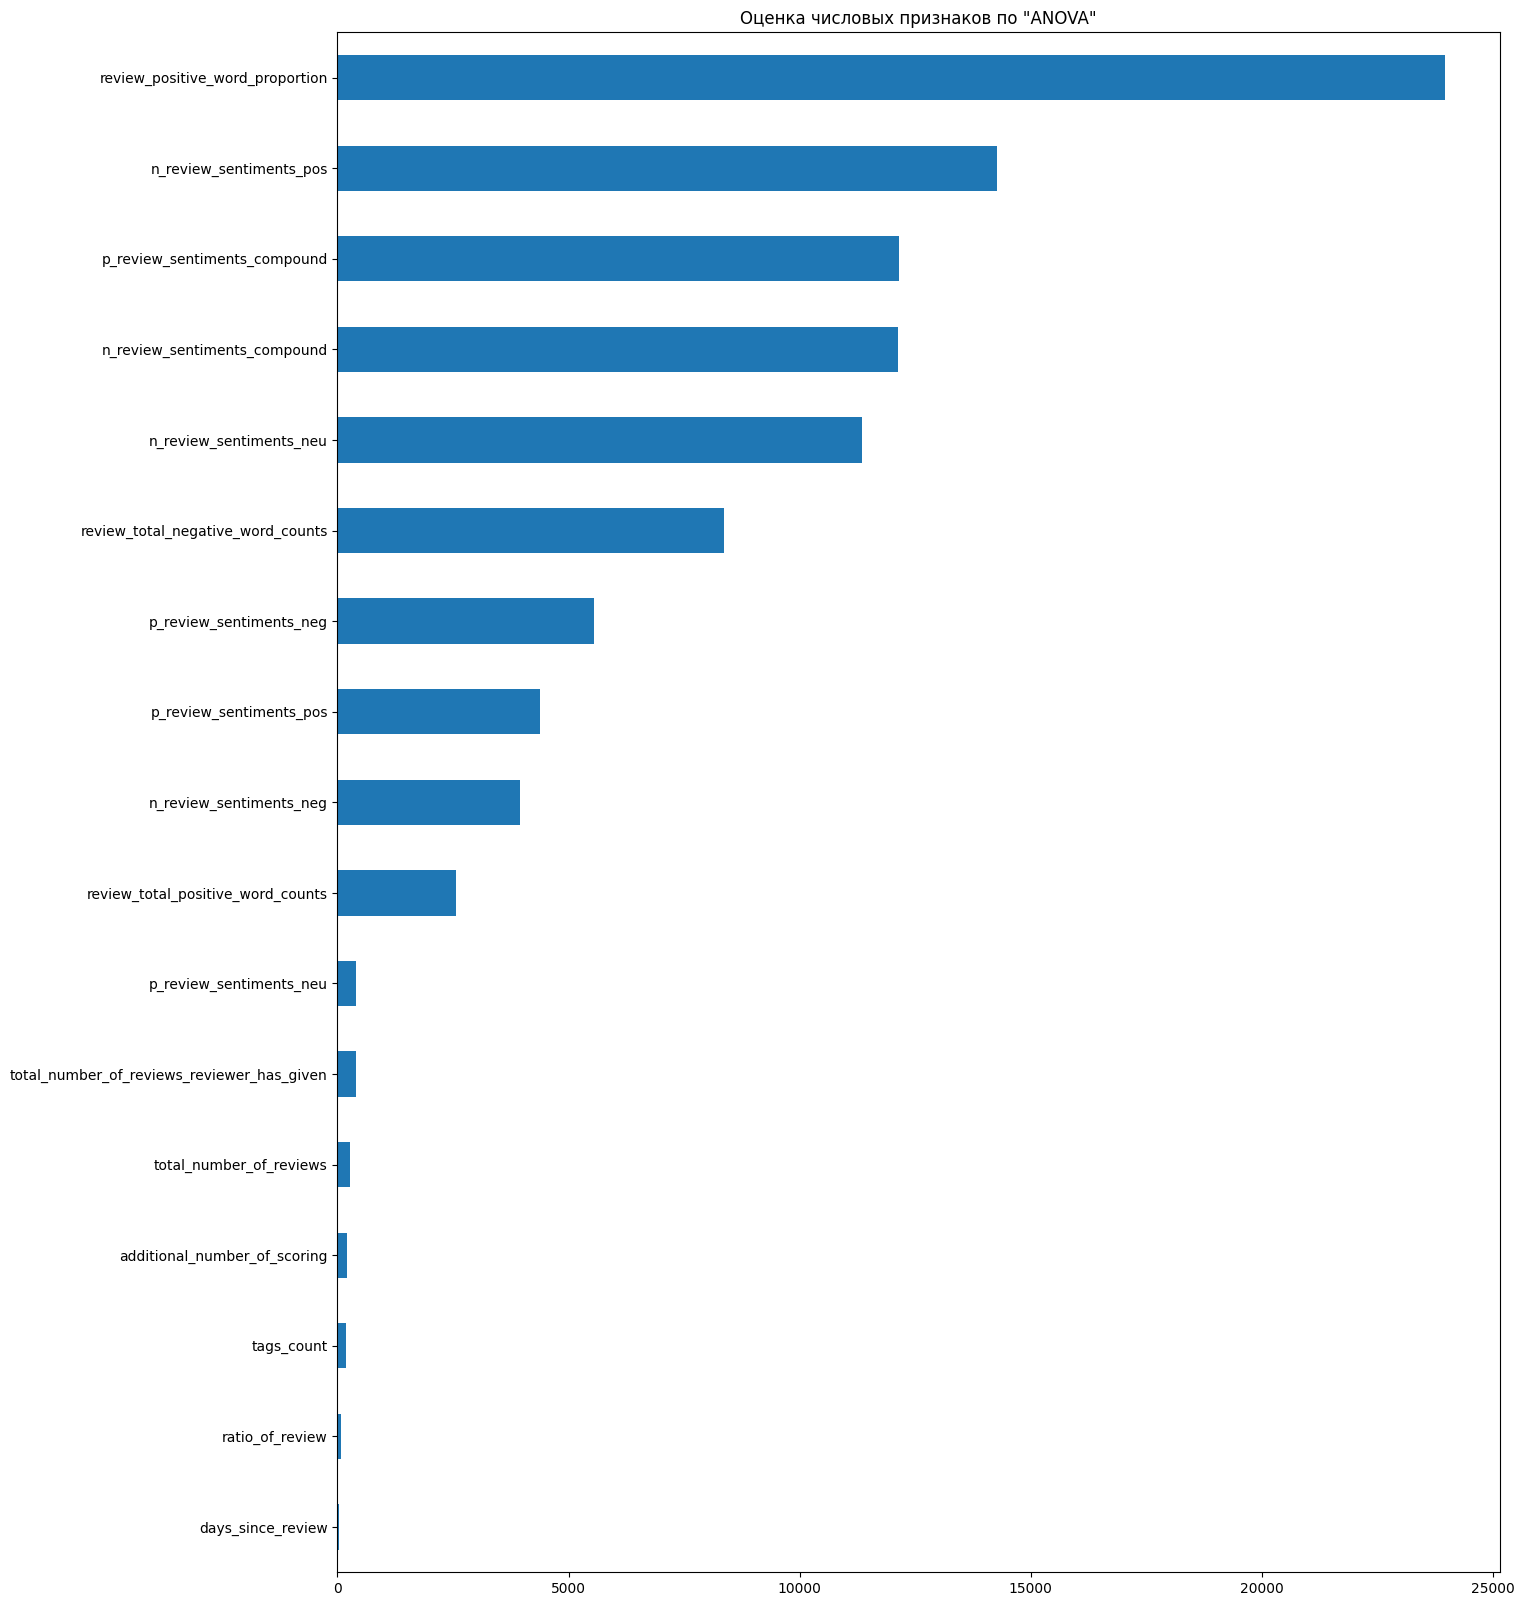

In [163]:
# графики числовых признаков

# тепловая матрица числовых признаков
show_corr_heatmap(
    num_cols, 
    method = 'pearson', 
    title_heat = 'Корреляция числовых признаков'
)

# визуализируем результат анализа значимости
# столбчатая диаграмма категориальных признаков по ANOVA
imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
_, ax_barh_anova = plt.subplots(figsize = (15, 20))
imp_num.plot(kind = 'barh', title='Оценка числовых признаков по "ANOVA"');

Так как удаление маловлияющих признаков влияет на точность модели (вплоть до 1-2 знака после запятой), то принято решение ограничиться удалением:
1) Неинформативных признаков, не влияющих на MAPE модели обучения:
    * lat
    * lng
2) Самые высококоррелирующие признаки:
    * additional_number_of_scoring
    * n_review_sentiments_pos

Остальные высококоррелирующие параметры оставлены для построения модели и их удалять не будет, т.к. их и создавали как вспомогательные для уточнения и корректировки при построении модели.

In [164]:
# признаки к удалению
drop_columns = [
    # просто ни с чем не связаны
    'lat', 
    'lng', 

    # имеют высокую корреляцию
    'additional_number_of_scoring', 
    'n_review_sentiments_pos', 
    # ===================================
    # 'average_score', 
    # 'hotel_country_code',

    # имеют очень маленькую корреляцию
    # 'days_since_review', 
    # 'tags_count', 
    # 'tag_from_mobile', 
    # 'tag_with_pet', 
    
    # экспериментальное удаление признаков
    # 'year_month_te',
    # 'reviewer_nationality_te',
    # 'p_review_sentiments_neu', 
    # 'ratio_of_review', 
]

data.drop(drop_columns, axis = 1, inplace = True)

# 4. Обучение модели

## 4.1 Вариант обучения модели с помощью модуля RandomForestRegressor

In [165]:
train_data = data[data['sample'] == 1].drop(['sample'], axis = 1)
test_data = data[data['sample'] == 0].drop(['sample'], axis = 1)

X = train_data.drop(['reviewer_score'], axis = 1)
y = train_data['reviewer_score'].values

# при помощи train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = TEST_SIZE, random_state=RANDOM_STATE
)

# проверяем данные
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 30), (386803, 30), (386803, 29), (309442, 29), (77361, 29))

In [166]:
# создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
rand_forest_regr = RandomForestRegressor(
    n_estimators = 100,
    verbose = 1,
    n_jobs = -1,
    random_state = RANDOM_STATE)

In [167]:
%%time

# Обучаем модель на тестовом наборе данных  
rand_forest_regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = rand_forest_regr.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   56.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.8min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.9s


CPU times: total: 17min 1s
Wall time: 2min 50s


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.0s finished


In [168]:
# сравниваем предсказанные значения (y_pred) с реальными (y_test)
# метрика Mean Absolute Error (MAE) показывает среднее отклонение предсказанных значений от фактических
# метрика Mean Absolute Percentage Error (MAPE) показывает среднюю абсолютную ошибку (в процентах) предсказанных значений от фактических
mae_forest_regr = metrics.mean_absolute_error(y_test, y_pred).round(8)
mape_forest_regr = (metrics.mean_absolute_percentage_error(y_test, y_pred) * 100).round(8)
print(f'MAE: {mae_forest_regr}\nMAPE: {mape_forest_regr}')

MAE: 0.84885587
MAPE: 12.04987098


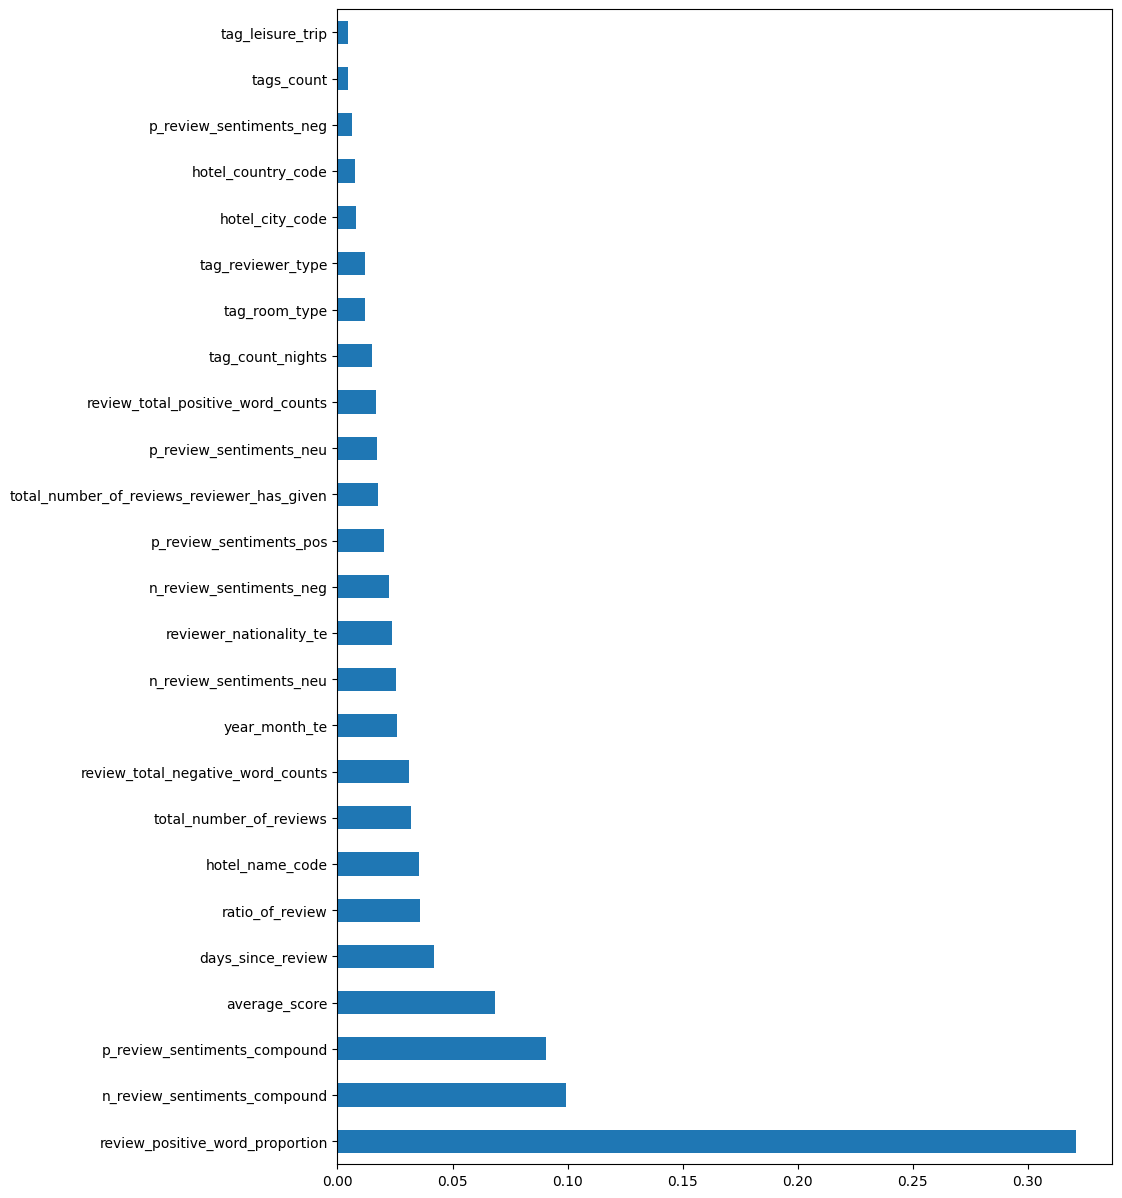

In [169]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10, 15)
feat_importances = pd.Series(rand_forest_regr.feature_importances_, index = X.columns)
feat_importances.nlargest(25).plot(kind = 'barh');

In [170]:
# предсказание целевой переменной
test_data = test_data.drop(['reviewer_score'], axis = 1)
predict_submission = rand_forest_regr.predict(test_data)
sample_submission[TARGET_NAME] = predict_submission

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    3.0s finished


In [171]:
# сохрание результата (сабмишн для загрузки и оценки)
sample_submission.to_csv(INPUT_DIR + 'submission_rfr.csv', index = False)

# знакомимся с данными
sample_submission.head(10)

,reviewer_score,id
0,8.002,488440
1,7.304,274649
2,7.867,374688
3,9.835,404352
4,9.604,451596
5,8.757,302161
6,8.170,317079
7,7.891,13963
8,8.506,159785
9,7.368,195089


## 4.2 Вариант обучения модели с помощью модуля LightAutoML

In [172]:
# разбиение на тренировочную и валидационную модели
# tr_data - тренировочные данные
# te_data - холдаут
tr_data, te_data = train_test_split(
    train_data, 
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE
)

In [173]:
# Task - объект из lightautoml
# определяем какую задачу мы решаем: бинарную 'binary', регрессии 'reg', мультикласс 'multiclass'
# В данном случае - регрессия, так как предсказываем вещественное число
task = Task('reg', loss = 'mae', metric = 'mae')

In [174]:
# задаём какая колонка является целевой и какие колонки лишние
roles = {
    'target': TARGET_NAME,
    'drop': []
}

In [175]:
# создаём объект TabularAutoML
automl = TabularAutoML(
    task = task, 
    timeout = TIMEOUT,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
)

In [176]:
# обучение модели (на каких данных обучаем, какой target, уровень отображения)
# после выполнения обучения мы получаем Out-of-Fold предсказание
# гасим уведомления о вычислениях, далее будут выведены рассчитанные модели
oof_pred = automl.fit_predict(tr_data, roles = roles, verbose = 0)

In [177]:
# информация о работе automl
print(automl.create_model_str_desc())

Final prediction for new objects (level 0) = 
	 0.69129 * (2 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
	 0.30871 * (1 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost) 


In [178]:
%%time

# обучение валидационной выборки
te_pred = automl.predict(te_data)
print(f'Prediction for te_data:\n{te_pred}\nShape = {te_pred.shape}')

Prediction for te_data:
array([[9.503793],
       [9.408762],
       [9.316399],
       ...,
       [9.132957],
       [9.079834],
       [9.194844]], dtype=float32)
Shape = (77361, 1)
CPU times: total: 13 s
Wall time: 9.08 s


In [179]:
# измеряем качество модели, сравнивая MAE на тренировочной и валидационной выборках
#print(f'TRAIN out-of-fold score: {metrics.mean_absolute_error(tr_data[TARGET_NAME].values, oof_pred.data[:, 0])}')
#print(f'HOLDOUT score: {metrics.mean_absolute_error(te_data[TARGET_NAME].values, te_pred.data[:, 0])}')

CPU times: total: 31.2 ms
Wall time: 101 ms


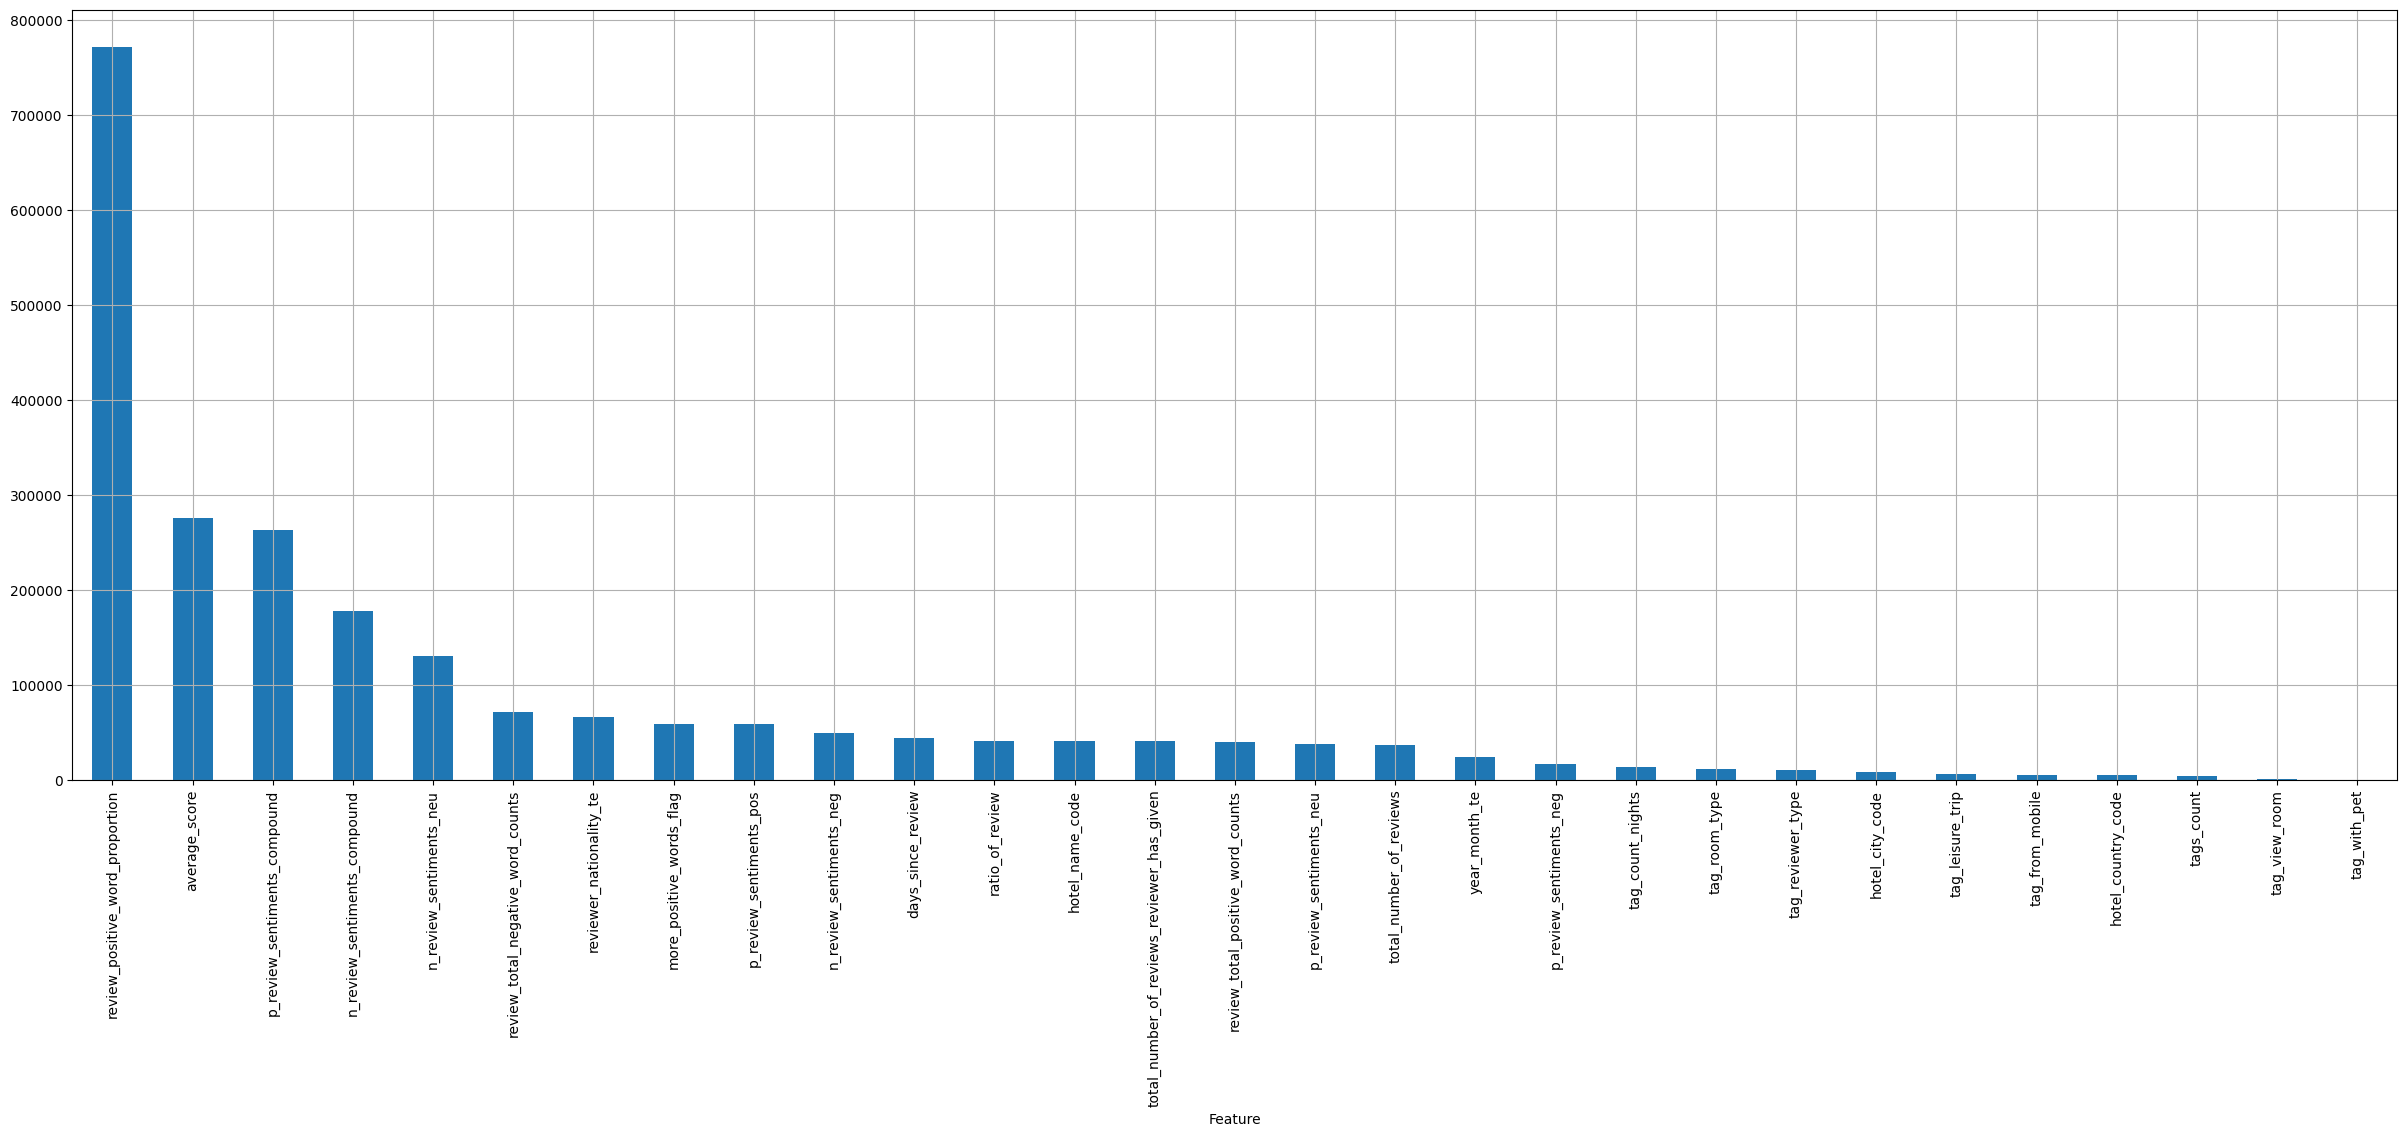

In [180]:
%%time

# оцениваем важность признаков в графическом виде - быстрый способ оценки параметров
fast_fi = automl.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True);

In [181]:
# оцениваем модель 
mae_automl = metrics.mean_absolute_error(te_data[TARGET_NAME].values, te_pred.data[:, 0]).round(8)
mape_automl = (metrics.mean_absolute_percentage_error(te_data[TARGET_NAME].values, te_pred.data[:, 0]) * 100).round(8)
print(f'MAE: {mae_automl}\nMAPE: {mape_automl}')

MAE: 0.80601705
MAPE: 11.74853823


In [182]:
# предсказание целевой переменной
predict_submission = automl.predict(test_data)
print(f'Prediction for te_data:\n{predict_submission}\nShape = {predict_submission.shape}')

Prediction for te_data:
array([[8.795228 ],
       [7.8895893],
       [8.337312 ],
       ...,
       [8.181118 ],
       [9.742027 ],
       [7.704746 ]], dtype=float32)
Shape = (128935, 1)


In [183]:
# сохрание результата (сабмишн для загрузки и оценки)
sample_submission[TARGET_NAME] = predict_submission.data[:, 0]
sample_submission.to_csv(INPUT_DIR + 'submission_laml.csv', index = False)

# знакомимся с данными
sample_submission.head(10)

,reviewer_score,id
0,8.795228,488440
1,7.889589,274649
2,8.337312,374688
3,9.977689,404352
4,9.864243,451596
5,8.733377,302161
6,7.941626,317079
7,7.914253,13963
8,8.949370,159785
9,7.639799,195089
